# Block VQE by Qubit

Here we will split the Hilbert space into two groups, one which will be calculated classically and the other with will be calculated using block-VQE.  Instead of splitting the Hilbert space into spin-up and spin-down as we did before, here I will split the Hilbert space into general sets of qubits.  

The wavefunction is divided into classical and quantum parts
$$
    |\psi> = \sum_c \alpha_c |c>|\psi_{qc}>
$$
where $|c>$ is a basis state in the classical section and $|\psi_q>$ is the wavefunction in the quantum section.  The weights $\alpha_c$ have to be solved classically while the wavefunctions $|\psi_{qc}>$ will be updated using VQE.  

Let's do a simple X-Y-Z model with closed boundary conditions to test the algorithm.  
$$ 
    H =  \sum_{i} \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right) 
$$

Let us take the first $N_c$ qubits to be in the classical sector.  Then we can take energy expectation values as,
\begin{equation}
\begin{split}
&<\psi|H|\psi> = \sum_{cc'}\alpha_c\alpha_c'<\psi_{qc'}|<c'| H |c> |\psi_{qc}>=
\\
& \sum_{cc'}\alpha_c\alpha_c' \left( \sum_{i=0}^{N_c-2}  <c'|\left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right)|c><\psi_{qc'}|\psi_{qc}>  + \delta_{cc'}\sum_{i=N_c+1}^{N} <\psi_{qc'}| \ \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right) |\psi_{qc}> \right) 
\\
&+ \sum_{cc'}\alpha_c\alpha_c'  \left( <c'|X_{N_c-1}|c><\psi_{qc'}|X_{N_c}|\psi_{qc}> + <c'|Y_{N_c-1}|c> <\psi_{qc'}|Y_{N_c}|\psi_{qc}> + <c'|Z_{N_c-1}|c><\psi_{qc'}|Z_{N_c}|\psi_{qc}> \right) 
\end{split}
\end{equation}

Anything in the classical brakets are calculated classically while anything in the quantum brackets are calculated using quantum hardware.  Notice that some of the quantum brakets are wieghted by classical brackets.  This is not a problem.  

In [27]:
#Only needed if running on the quantum device
from qiskit import IBMQ,transpile
from qiskit.tools.monitor import job_monitor
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-afrl', group='air-force-lab', project='quantum-sim')
#backend = provider.get_backend('ibmq_bogota')
backend = provider.get_backend('ibmq_manila')

ibmqfactory.load_account:WARNING:2021-11-01 14:11:07,664: Credentials are already in use. The existing account in the session will be replaced.


## Classical part

### Define Pauli Matrices

Let us define the Pauli matrices so we can do the classical calculations.

In [2]:
import qiskit.quantum_info as qi

def X(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'X'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Y(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'Y'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Z(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'Z'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

### Generate the states

We need a function which gives you the classical basss for a given number of qubits.

In [3]:
# A function to print the state given the numerical represenations
def bi(num,N):
    bi = bin(num)
    out = []
    Sdiff = N - len(bi) + 2
    for i in range(0,Sdiff):
        out.append(0)
    for i in range(2,len(bi)):
        out.append(int(bi[i]))
    return out

# A function which retruns the numerical representation of states given N
def states(N):
    out = [i for i in range(0,2**N)]
    return out

# A function to print the basis vectors given the number of qubits N
def vecs(N):
    out = []
    for i in range(2**N):
        v = [0 for i in range(2**N)]
        v[i] = 1
        out.append(v)
    return out

In [4]:
import numpy as np

def Mdot(Ol):
    out = Ol[0]
    for i in range(1,len(Ol)):
        out = np.dot(Ol[i],out)
    return out

def bkt(y1,O,y2):
    return Mdot([np.conjugate(y1),O,y2])


### Full Hamiltoniain

Let us write the un-partitioned Hamiltonain so we can compare to it later.

In [5]:
def H(x,y,z,N):
    h = 0*X(0,N)
    for i in range(0,N-1):
        h += x*Mdot([X(i,N),X(i+1,N)]) + y*Mdot([Y(i,N),Y(i+1,N)]) + z*Mdot([Z(i,N),Z(i+1,N)])
    return h
        
    
import pandas as pd
#pd.DataFrame(H(1,2,3,4))

### Calculating the classical brakets

We can calculate all of the classical brakets before we start VQE.  Once we have the value of each braket we simply store it as a weight for the various quantum brakets.  There are five types of classical brakets we need to calculate.

\begin{equation}
\begin{split}
& T_{c,c'} =  <c'|\sum_{i=0}^{N_c-2}\left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right)|c> 
\\
& B1^x_{c,c'} =  x<c'|X_{N_c-1}|c>
\\
&B1^y_{c,c'} = y<c'|Y_{N_c-1}|c> 
\\
&B1^z_{c,c'} = z<c'|Y_{N_c-1}|c> 
\end{split}
\end{equation}

In [6]:
def T(x,y,z,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    for i in range(0,Nc-1):
        O = x*Mdot([X(i,Nc),X(i+1,Nc)]) + y*Mdot([Y(i,Nc),Y(i+1,Nc)]) + z*Mdot([Z(i,Nc),Z(i+1,Nc)])
        out += bkt(v[cc],O,v[c])
    return out

def Bx(x,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = X(Nc-1,Nc)
    out += bkt(v[cc],x*O,v[c])
    return out

def By(y,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = Y(Nc-1,Nc)
    out += bkt(v[cc],y*O,v[c])
    return out

def Bz(z,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = Z(Nc-1,Nc)
    out += bkt(v[cc],z*O,v[c])
    return out



We Can use these to rewrite the Hamiltoniain.  I will shift the indicies so $ N_c \rightarrow 0 $.

\begin{equation}
\begin{split}
H_{c,c'}=& T_{c,c'} + \delta_{cc'}\sum_{i=0}^{N_q} \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1}  + z Z_{i} Z_{i+1}\right) 
\\
&+ \left(B^{1x}_{c,c'}X_{0} + B^{1y}_{c,c'} Y_{0} + B^{1z}_{c,c'} Z_{0} \right)
\end{split}
\end{equation}

In [7]:
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit import quantum_info as qi


def H_quantum(x,y,z,c,cc,Nc,Nq):
    tcc = T(x,y,z,c,cc,Nc)
    Iq = np.identity(2**Nq)
    h = tcc*Iq
    h += Bx(x,c,cc,Nc)*X(0,Nq)
    h += By(y,c,cc,Nc)*Y(0,Nq)
    h += Bz(z,c,cc,Nc)*Z(0,Nq)
    if c == cc:
        for i in range(0,Nq-1):
            h += x*Mdot([X(i,Nq),X(i+1,Nq)]) + y*Mdot([Y(i,Nq),Y(i+1,Nq)]) + z*Mdot([Z(i,Nq),Z(i+1,Nq)])
    return h
    
    
#H_quantum(1,1,1,3,2,2,2)

In [8]:
def H_quantum(x,y,z,c,cc,Nc,Nq):
    tcc = T(x,y,z,c,cc,Nc)
    Iq = np.identity(2**Nq)
    h = [MatrixOp(tcc*Iq).to_pauli_op()]
    h.append(MatrixOp(Bx(x,c,cc,Nc)*X(0,Nq)).to_pauli_op())
    h.append(MatrixOp(By(y,c,cc,Nc)*Y(0,Nq)).to_pauli_op())
    h.append(MatrixOp(Bz(z,c,cc,Nc)*Z(0,Nq)).to_pauli_op())
    if c == cc:
        for i in range(0,Nq-1):
            h.append(MatrixOp(x*Mdot([X(i,Nq),X(i+1,Nq)])).to_pauli_op())
            h.append(MatrixOp(y*Mdot([Y(i,Nq),Y(i+1,Nq)])).to_pauli_op())
            h.append(MatrixOp(z*Mdot([Z(i,Nq),Z(i+1,Nq)])).to_pauli_op())
    return h

In [9]:
from qiskit.opflow import SummedOp, PauliOp

def Blocks(x,y,z,Nc,Nq):
    bks = {}
    Mc = len(states(Nc))
    for c in range(0,Mc):
        for cc in range(0,Mc):
            Op = H_quantum(x,y,z,c,cc,Nc,Nq)
            bks[str(c) + ',' + str(cc)] =  Op
    return bks
        
    

In [10]:
Blocks(1,2,3,2,2)['0,0']

[PauliOp(Pauli('II'), coeff=3.0),
 PauliOp(Pauli('II'), coeff=0.0),
 PauliOp(Pauli('II'), coeff=0.0),
 PauliOp(Pauli('ZI'), coeff=3.0),
 PauliOp(Pauli('XX'), coeff=1.0),
 PauliOp(Pauli('YY'), coeff=2.0),
 PauliOp(Pauli('ZZ'), coeff=3.0)]

Let us check that we can rebuild the Hamiltoniain.

In [11]:
Nc = 2
Nq = 3
x = 1
y = 2
z = 3
blocks = Blocks(x,y,z,Nc,Nq)

keys = list(blocks.keys())

bL = len(states(Nc))
size = 2**Nq
H_complete = np.array([[0 for i in range(size*bL)] for j in range(size*bL)])

for bi in range(bL):
    for bj in range(bi,bL):
        key = str(bi) + ',' + str(bj)
        if key  in keys:
            hl = blocks[key]
            block = np.sum(hl).to_matrix()
        else:
            block = np.array([[0.0 for i in range(size)] for j in range(size)])
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]
                

<ipython-input-11-ef49c2b99a7a>:24: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-11-ef49c2b99a7a>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [12]:
np.amax(np.abs(H_complete - np.real(H(x,y,z,Nc+Nq))))

0.0

## Anzats Circuit

Here we define the paramaterized circuit which we will optimize. 

$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$

In [13]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute

Q = Nq

### Diagonal Blocks

In [14]:
def Ui(cir_i,phi_i):  
    
    for q in range(0,Q):
        cir_i.ry(phi_i[q],q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

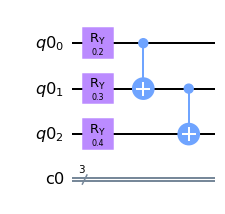

In [15]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst = Ui(cir_i,[0.2,0.3,0.4])

tst.draw(output = 'mpl')

In [16]:
def U(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui(cir,phi_b[t])
    return cir

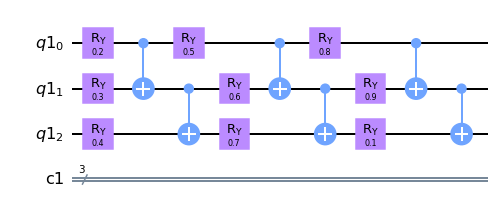

In [17]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]])

tst.draw(output = 'mpl')

### Off Diagonal Blocks

In [18]:
def Ui_off(cir_i,phi_a, phi_b):  
    
    for q in range(0,Q):
        cir_i.ry(phi_a[q],q)
        cir_i.cx(Q,q)
        cir_i.ry(-(phi_b[q]-phi_a[q])/2,q)
        cir_i.cx(Q,q)
        cir_i.ry((phi_b[q]-phi_a[q])/2,q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

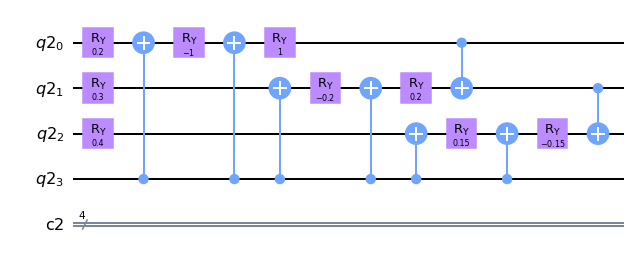

In [19]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
tst = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

tst.draw(output = 'mpl')

In [20]:
#An example block a circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_a = Ui(cir_i,[0.2,0.3,0.4])

#An example block b circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_b = Ui(cir_i,[2.2,0.7,0.1])

#The combination of the two blocks
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
cir_i.h(Q)
tst_off = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

print('A:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_a).data)
print('B:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_b).data)
print('AB:')
print(qi.Statevector.from_instruction(tst_off).data)

A:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j]
B:
[0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]
AB:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j
 0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]


In [21]:
def U_off(cir,phi_a,phi_b):
    T = len(phi_b)
    cir.h(Q)
    for t in range(T):
        cir = Ui_off(cir,phi_a[t],phi_b[t])
    return cir

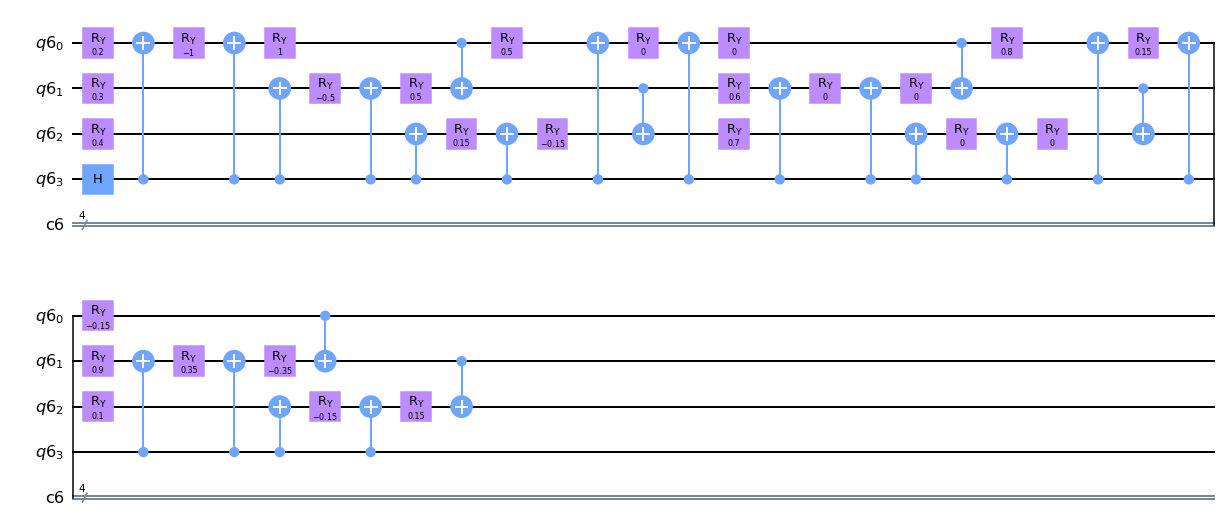

In [22]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir = QuantumCircuit(qr , cr)
tst = U_off(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]],[[2.2,1.3,0.1],[0.5,0.6,0.7],[0.5,0.2,0.4]])

tst.draw(output = 'mpl')

# Calculating E

$$ E = \sum_{ab}<\psi^a|H_{ab}|\psi^b> = \sum_{ab}<000\ldots|U^{\dagger}(\{\phi^a\})H_{ab}U(\{\phi^b\})|000\ldots>$$

each $H_{ab}$ can be brocken down into its Puali components so that $H_{ab} = \sum_p c_p P_{ab,p}$.  Then we have

$$ E = \sum_{ab}\sum_p c_p <000\ldots|U^{\dagger}(\{\phi^a\})  P_{ab,p}U(\{\phi^b\})|000\ldots>$$.

We cannot measure $<\psi^a|P_{ab,p}|\psi^b>$ directly.  Instead we measure $|<\psi^a|P_{ab,p}|\psi^b>|^2$ which tells us nothing about the sign.  

To fix the issue we need to find a way to use the counts to recreate the desired measurement.  This can be done by looking at the counts in each occupation state. 

First we need to go through the circuit and add a $R_y(-\pi/2)$ gate on each qubit where $P_{ab,p}$ applies an X and an $R_x(\pi/2)$ gate to each qubit where $P_{ab,p}$ applies an Y.  This rotates all of the Pauli terms to Z.   Then we can take the count for each occupation state mulitply that count by $(-1)^n$ where n is the number of up qubits with a Puali term in $P_{ab,p}$. 

for example:

\begin{equation}
\begin{split}
<\psi|XZ|\psi> &= <(R_y(\pi/2)\otimes I)\psi|R^{\dagger}_y(\pi/2)XR_y(\pi/2)\otimes Z|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = <(R_y(\pi/2)\otimes I)\psi|ZZ|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = |<00|R^{\dagger}_y(\pi/2)\psi>|^2 + (-1)^1|<10|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^1|<01|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^2|<11|R^{\dagger}_y(\pi/2) \psi>|^2
\end{split}
\end{equation}

This unfortunetly does not work for $|\psi^a> \neq |\psi_b>$



In [28]:
from qiskit import Aer
from qiskit.visualization import *
from qiskit import quantum_info as qi

def measure_pauli(p_label,psi0,method = 'simple'):
    
    #Simple method of calculation####
    if method == 'simple':
        wave0 = qi.Statevector.from_instruction(psi0)
        Op = qi.Operator.from_label(p_label)
        return np.dot(np.conjugate(wave0),np.dot(Op,wave0))
    #################################
        
    #apply rotations#################
    psi = copy.deepcopy(psi0)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'
    ################################
    
    #Using matrix multiplication####
    if method == 'matrix':
        # add results
        wave = qi.Statevector.from_instruction(psi)
        r = wave.probabilities_dict()
        z_measure = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
        return z_measure
    #################################
    
    #Using the qasm simulator########
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        psi.measure(psi.qubits,psi.clbits)
        r = execute(psi, backend = sim).result().get_counts()
        z_measure = 0
        total = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
            total += r[key]
        return z_measure/total
    ###################################
    
    #Using the quantum backend#########
    if method == "quantum":
        psi.measure(psi.qubits,psi.clbits)
        job = backend.run(transpile(psi, backend), meas_level=2, shots=8192) 
        print("job id: ",job.job_id())
        print(job_monitor(job))
        r = job.result().get_counts()
        z_measure = 0
        total = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
            total += r[key]

        z_measure/total
        return z_measure/total
    ###################################
    
    raise NameError(method + ' is not a recognized method')
    return method + ' is not a recognized method'
  

#Run a test
import copy
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,[[1.2,2.3,3.4]])
p_label = blocks['0,0'][7].primitive.to_label()
        
    
print( measure_pauli(p_label,psi0,method = 'simple') )
print( measure_pauli(p_label,psi0,method = 'matrix') )
print( measure_pauli(p_label,psi0,method = 'simulator') )
#print( measure_pauli(p_label,psi0,method = 'Moon_Cheese') )

(-0.2381742951601455+0j)
-0.2381742951601454
-0.177734375


In [ ]:
print( measure_pauli(p_label,psi0,method = 'quantum') )

job id:  61802dc63a3feb4723dbfb64
Job Status: job is queued (1)     

In order to calculate things like 
$$<\psi^a|ZZ|\psi^b>$$ 
we will need to add another qubit and build the combined statevector 
$$ |\psi^{ab}> = |0>|\psi^a> + |1>|\psi_b> $$
then we can calculate
$$ <\psi^{ab}|X\otimes ZZ|\psi^{ab}> = <\psi^{ab}|\left(|1>ZZ|\psi^a> + |0>ZZ|\psi_b> \right) = <\psi^{a}|ZZ|\psi^{b}> + <\psi^{b}|ZZ|\psi^{a}>  $$ 
$$ <\psi^{ab}|Y\otimes ZZ|\psi^{ab}> = <\psi^{ab}|\left(|1>ZZ|\psi^a> + |0>ZZ|\psi_b> \right) = i<\psi^{a}|ZZ|\psi^{b}> - i<\psi^{b}|ZZ|\psi^{a}>  $$ 

$$ <\psi^{ab}|X\otimes ZZ|\psi^{ab}> +  i <\psi^{ab}|Y\otimes ZZ|\psi^{ab}> = <\psi^{a}|ZZ|\psi^{b}> $$

In order to form the combined statevector we need to create a circuit which performs 
$$ U^{ab} = I\otimes U^a + X \otimes U^b$$
This as done in the Ansatz section.   Here we will use that result to calculate E.

In [23]:
import random

alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#Create an arbitrary collection of rotation angles
T = 1
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            rand = random.random()
            phi_t.append(rand)
        phi_b.append(phi_t)
    phi.append(phi_b)

#Find the energy contribution from diagonal blocks
def E_on_block(phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi0 = U(cir,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_p = measure_pauli( p_label,psi,method = method)
        E += w*E_p
    return E
        
        
block = blocks['0,0']
phi_b = phi[0]

M_b = np.sum(block).to_matrix()
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,phi_b)
wave = qi.Statevector.from_instruction(psi0).data
print('check:',np.dot(np.conjugate(wave),np.dot(M_b,wave)))

print('simple:',E_on_block(phi_b,block,method = 'simple'))
print('matrix:',E_on_block(phi_b,block,method = 'matrix'))
print('simulator:',E_on_block(phi_b,block,method = 'simulator'))
#print('mooncheese:',E_on_block(phi_b,block,method = 'mooncheese'))

check: (8.01165465488223+0j)
simple: (8.01165465488223+0j)
matrix: 8.011654654882228
simulator: 8.216796875


In [24]:
# Find the energy contribution from off diagonal blocks
def E_off_block(phi_a,phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir = QuantumCircuit(qr , cr)
    psi0 = U_off(cir,phi_a,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_px = measure_pauli('X' + p_label,psi,method = method)
        E_py = measure_pauli('Y' + p_label,psi,method = method)
        E += w*(E_px + 1j*E_py)/2
    return E

block = blocks['0,1']
phi_a = phi[0]
phi_b = phi[1]
M_b = np.sum(block).to_matrix()
#A
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_a = U(cir,phi_a)
wave_a = qi.Statevector.from_instruction(psi_a).data
#B
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_b = U(cir,phi_b)
wave_b = qi.Statevector.from_instruction(psi_b).data
print('check:',1/2*np.dot(np.conjugate(wave_a),np.dot(M_b,wave_b)))

print('simple:',E_off_block(phi_a,phi_b,block,method = 'simple'))
print('matrix:',E_off_block(phi_a,phi_b,block,method = 'matrix'))
print('simulator:',E_off_block(phi_a,phi_b,block,method = 'simulator'))
#print('mooncheese:',E_off_block(phi_a,phi_b,block,method = 'mooncheese'))

check: (0.46911407649415165+0j)
simple: (0.46911407649415177+0j)
matrix: (0.469114076494152+1.1796119636642288e-16j)
simulator: (0.490234375+0.017578125j)


In [25]:
# The total energy 
def find_E(alpha,phi,blocks,method = 'simple'):
    E = 0
    for key in list(blocks.keys()):
        if key[0] == key[2]:
            E += alpha[int(key[0])]*alpha[int(key[2])]*E_on_block(phi[int(key[0])],blocks[key],method = method)
        else:
            E += 2*alpha[int(key[0])]*alpha[int(key[2])]*E_off_block(phi[int(key[0])],phi[int(key[2])],blocks[key],method = method)
    return E
            
find_E(alpha,phi,blocks)

(5.639463598383605+0j)

In [26]:
#Check against H_complete               
wave_full = []
for b in range(bL):
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi_b = U(cir,phi[b])
    wave_b = alpha[b]*qi.Statevector.from_instruction(psi_b).data
    wave_full.append(wave_b)
wave_full = np.array(wave_full).flatten()

np.dot(np.conjugate(wave_full),np.dot(H_complete,wave_full))


(5.639463598383604+0j)

First we need to inialize our set of parameters.  To do this we need to decide on the number of times we will apply Ui.  As a first attempt let's just have a depth of 1 (i.e. $U = Ui$).  

In this case, we need a parameter for each qubit for each section.

In [27]:
alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#number of blocks
T = 2
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            phi_t.append(0)
        phi_b.append(phi_t)
    phi.append(phi_b)
    
find_E(alpha,phi,blocks)

(7+0j)

# Optimizaition

I will be using the simultaneous perturbation stochastic approximation algorithm.  The algorithm works by calculating the gradiant of the cost function $E(\hat{\phi})$ by randomly purturbating all parameters in $\hat{\phi}$

Let $\hat{\Delta}_k$ be a set of randomly selected purturbations during step $k$ of the algorithm. I will use the Bernoulli distribution to select $\hat{\Delta}_k$.  Then the gradient is 
$$ \hat{g}_k(\hat{\phi}_k) = \frac{E(\hat{\phi}_k + c_k \hat{\Delta}_k)-E(\hat{\phi}_k - c_k \hat{\Delta}_k)}{2 c_k} \hat{\Delta}_k$$.
The gradiant is then used to update the parameters 
$$ \hat{\phi}_{k+1} = \hat{\phi}_k - a_k \hat{g}_k(\hat{\phi}_k) $$

$c_k$ and $a_k$ decrease with each iteration of the algorithm so that we zero in on the the minimum of $E$.  They are given by
$$c_k = \frac{c}{(k+1)^{\gamma}}$$
$$a_k = \frac{a}{(A+k+1)^{\alpha}}$$
where $a$, $A$, $\alpha$, $c$, and $\gamma$ are choosen at the begining of the algorithm.

In [28]:
import copy

In [29]:
#beta = 0.602
beta = 0.201
A = 10
a = 0.05
gamma = 0.101
c = 0.4

beta_a = 0.201
A_a = 10
a_a = 0.05
gamma_a = 0.101
c_a = 0.4

def SPSA(k_max,method = 'simple',hold = False):
    #Initalization
    k = 0
    phi_k = np.array(phi)
    alpha_k = np.array(alpha)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)
        a_ak = a_a/((A_a + k + 1)**beta_a)
        c_ak = c_a/((k + 1)**gamma_a)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for t in range(T):
                for q in range(Q):
                    Delta_k[b][t][q] = 1 - 2*np.random.binomial(size=None, n=1, p=0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta Alpha
        Delta_ak = np.array(alpha_k)
        for n in range(bL):
            Delta_ak[n] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        alpha_k_A = alpha_k + c_ak*Delta_ak
        alpha_k_B = alpha_k - c_ak*Delta_ak
        norm_A = 1/np.sqrt(np.dot(alpha_k_A,alpha_k_A))
        norm_B = 1/np.sqrt(np.dot(alpha_k_B,alpha_k_B))
        alpha_k_A = norm_A*alpha_k_A
        alpha_k_B = norm_B*alpha_k_B
            
        #Find E    
        E_A = find_E(alpha_k_A, phi_k_A, blocks, method = method)
        E_B = find_E(alpha_k_B, phi_k_B, blocks, method = method)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update alpha
        g_ak = g * Delta_ak
        alpha_k = alpha_k - a_ak * g_ak
        norm = 1/np.sqrt(np.dot(alpha_k,alpha_k))
        alpha_k = norm*alpha_k

        
        #Calculate new E
        E_f = np.real(find_E(alpha_k,phi_k,blocks, method = method))
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k,'c_a':c_ak,'a_a':a_ak,'alpha':alpha_k,'Delta_a':Delta_ak}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [30]:
out = SPSA(3000,method = 'simple',hold = True)

k= 0 c_k= 0.4 a_k= 0.030878064824598282 g= 3.986765462242025 E_A= (6.530249192849833+0j) E_B= (3.3408368230562133+0j) E_f= 5.516308431934765
k= 1 c_k= 0.372954594574733 a_k= 0.030342724499598534 g= -2.4964479676319122 E_A= (2.267060324806903+0j) E_B= (4.129183804097055+0j) E_f= 5.309406000212878
k= 2 c_k= 0.3579898757427053 a_k= 0.029858459038837503 g= 1.2301184190707743 E_A= (3.702110043137879+0j) E_B= (2.8213701631539596+0j) E_f= 5.371924399994468
k= 3 c_k= 0.34773782403600867 a_k= 0.029416992458941946 g= 3.66590722562494 E_A= (7.97598879161523+0j) E_B= (5.426439588101834+0j) E_f= 5.2511834865046065
k= 4 c_k= 0.33998833831625347 a_k= 0.02901186589249766 g= -0.7026647838521 E_A= (4.728215073934755+0j) E_B= (5.206010738445205+0j) E_f= 5.293422527399111
k= 5 c_k= 0.3337849224236992 a_k= 0.028637947449493925 g= -1.078216912981151 E_A= (5.202190536221522+0j) E_B= (5.92197563353219+0j) E_f= 5.241033975132917
k= 6 c_k= 0.32862839767254015 a_k= 0.028291095918097278 g= 0.3064546526359418 E_A=

k= 52 c_k= 0.267860162826851 a_k= 0.021742153317333094 g= -4.542453212783156 E_A= (-8.520377172014888+0j) E_B= (-6.086892657595991+0j) E_f= -10.263383694185151
k= 53 c_k= 0.26735494522142605 a_k= 0.021673439087867164 g= -9.405751182032427 E_A= (-9.687790541135849+0j) E_B= (-4.658442357058563+0j) E_f= -10.153827524314066
k= 54 c_k= 0.2668599250350944 a_k= 0.02160600238280336 g= -4.19362197705391 E_A= (-8.938928591636955+0j) E_B= (-6.7007092987926935+0j) E_f= -10.051483535653313
k= 55 c_k= 0.26637471655715955 a_k= 0.021539800337028216 g= -8.161690848377473 E_A= (-10.871582601780418+0j) E_B= (-6.523446429052992+0j) E_f= -11.569855641947804
k= 56 c_k= 0.2658989552298248 a_k= 0.02147479214577462 g= -1.077536633201121 E_A= (-8.426877933503771+0j) E_B= (-7.853846203523689+0j) E_f= -11.64024880935056
k= 57 c_k= 0.26543229614067565 a_k= 0.021410938936572577 g= -4.675498523185112 E_A= (-8.924245341998937+0j) E_B= (-6.442188724776212+0j) E_f= -11.128374184731614
k= 58 c_k= 0.26497441264651617 a_k

k= 103 c_k= 0.25023014297472496 a_k= 0.019298881045265278 g= -15.786749844091837 E_A= (-11.218349861381686+0j) E_B= (-3.3177085201950516+0j) E_f= -10.856385526207713
k= 104 c_k= 0.24998840873867942 a_k= 0.019265032163888564 g= 3.675692090008488 E_A= (-8.289839148006552+0j) E_B= (-10.127599981195697+0j) E_f= -11.299626013513768
k= 105 c_k= 0.24974919607452548 a_k= 0.01923153495014902 g= -1.62798665308906 E_A= (-9.6366698600624+0j) E_B= (-8.8234931444043+0j) E_f= -11.181339764597158
k= 106 c_k= 0.2495124552599996 a_k= 0.01919838276571559 g= 10.92370397771381 E_A= (-5.249365452642028+0j) E_B= (-10.700565852667621+0j) E_f= -11.006833274111976
k= 107 c_k= 0.24927813800651724 a_k= 0.019165569152951475 g= -6.460425216824964 E_A= (-10.468952428365801+0j) E_B= (-7.2480668908048465+0j) E_f= -11.799163376992336
k= 108 c_k= 0.24904619740500722 a_k= 0.01913308782851349 g= -8.318832216455126 E_A= (-10.8844877494153+0j) E_B= (-6.7409406886984655+0j) E_f= -11.638605877528128
k= 109 c_k= 0.248816587874

k= 154 c_k= 0.24034577371294386 a_k= 0.017916605514221893 g= -3.936757211075013 E_A= (-10.441569372810731+0j) E_B= (-8.549203457179061+0j) E_f= -12.320874353744662
k= 155 c_k= 0.2401897150315199 a_k= 0.017894858911911237 g= 7.754397129565861 E_A= (-7.353854768466937+0j) E_B= (-11.078907642050257+0j) E_f= -12.073646668530976
k= 156 c_k= 0.24003475389827156 a_k= 0.017873269078684573 g= 1.5403303877746888 E_A= (-9.689260613859629+0j) E_B= (-10.428726264962682+0j) E_f= -12.057130619250005
k= 157 c_k= 0.23988087567680955 a_k= 0.017851833955768864 g= -0.5458756846114317 E_A= (-10.048736223846772+0j) E_B= (-9.786845949376236+0j) E_f= -12.034568623206324
k= 158 c_k= 0.239728066017013 a_k= 0.01783055152347874 g= 5.138647050181427 E_A= (-8.272665191947574+0j) E_B= (-10.736421030515618+0j) E_f= -12.493817867638622
k= 159 c_k= 0.23957631084767136 a_k= 0.01780941980024826 g= -2.409384523418404 E_A= (-10.818049947214387+0j) E_B= (-9.663587036146275+0j) E_f= -12.42590940729249
k= 160 c_k= 0.239425596

k= 205 c_k= 0.23353899237344763 a_k= 0.016972460255372947 g= -5.474191108236896 E_A= (-10.479826194592997+0j) E_B= (-7.922952043638334+0j) E_f= -12.343801000510501
k= 206 c_k= 0.23342479519724088 a_k= 0.016956710197876357 g= 5.027318194821117 E_A= (-8.50809729980443+0j) E_B= (-10.855098739839393+0j) E_f= -12.166118021935315
k= 207 c_k= 0.23331120380879006 a_k= 0.016941047069765323 g= 0.7612658626601173 E_A= (-9.486321313906618+0j) E_B= (-9.841545023578156+0j) E_f= -12.137433046342014
k= 208 c_k= 0.2331982121051757 a_k= 0.016925469995779104 g= -0.3883868953400657 E_A= (-9.22325947970412+0j) E_B= (-9.042117220507354+0j) E_f= -12.112508069969739
k= 209 c_k= 0.23308581407379206 a_k= 0.016909978113415238 g= 2.5975945710824697 E_A= (-8.602923665580159+0j) E_B= (-9.813848556048999+0j) E_f= -11.93744824844209
k= 210 c_k= 0.232974003790588 a_k= 0.01689457057268661 g= 1.1881598786370442 E_A= (-9.432136370927445+0j) E_B= (-9.985757099066268+0j) E_f= -12.014293085908434
k= 211 c_k= 0.2328627754183

k= 256 c_k= 0.22837930441497245 a_k= 0.01626451962299262 g= 1.3605654343381384 E_A= (-9.504234857942908+0j) E_B= (-10.125684832953306+0j) E_f= -12.153847359086301
k= 257 c_k= 0.22828974396591784 a_k= 0.016252303008687845 g= 0.4698754270618078 E_A= (-10.310833426154053+0j) E_B= (-10.525368908033686+0j) E_f= -12.183709007308726
k= 258 c_k= 0.22820056489801344 a_k= 0.01624014101894129 g= 0.7515384766332744 E_A= (-9.706276998330095+0j) E_B= (-10.049280008150706+0j) E_f= -12.230653145250185
k= 259 c_k= 0.22811176412405826 a_k= 0.01622803320780049 g= -4.683474381847921 E_A= (-11.011509896247905+0j) E_B= (-8.87479868930158+0j) E_f= -12.118618428150636
k= 260 c_k= 0.22802333859359442 a_k= 0.016215979134588294 g= 2.954273832404924 E_A= (-9.585899040155287+0j) E_B= (-10.933185804924614+0j) E_f= -12.019126669131328
k= 261 c_k= 0.22793528529233112 a_k= 0.016203978363821238 g= 5.402694774210838 E_A= (-8.780861174245352+0j) E_B= (-11.24379072365962+0j) E_f= -12.047722653360214
k= 262 c_k= 0.22784760

k= 307 c_k= 0.2242416957476633 a_k= 0.015702982735919514 g= 2.5840733688477457 E_A= (-9.985446554137651+0j) E_B= (-11.144360542471242+0j) E_f= -12.48481756957521
k= 308 c_k= 0.22416829307647623 a_k= 0.015693075965474278 g= 3.1652920308850145 E_A= (-9.360179581703605+0j) E_B= (-10.779295805007738+0j) E_f= -12.44327787537466
k= 309 c_k= 0.22409515148215373 a_k= 0.015683206422906985 g= -8.028629933295436 E_A= (-11.914837038803777+0j) E_B= (-8.316482956611788+0j) E_f= -12.741932801889465
k= 310 c_k= 0.2240222691984007 a_k= 0.01567337385263873 g= 2.758932448998801 E_A= (-10.333942441154669+0j) E_B= (-11.570067056734294+0j) E_f= -12.91915424277028
k= 311 c_k= 0.2239496444765029 a_k= 0.015663578001634454 g= 4.795354490287233 E_A= (-9.233378870015217+0j) E_B= (-11.381214736492472+0j) E_f= -12.80617158326497
k= 312 c_k= 0.22387727558509607 a_k= 0.015653818619369854 g= 1.3754281736520522 E_A= (-9.812568601137167+0j) E_B= (-10.428422825697579+0j) E_f= -12.85246369383074
k= 313 c_k= 0.223805160809

k= 358 c_k= 0.22079816106773162 a_k= 0.015240446991449733 g= 1.1222626050865803 E_A= (-11.363099576401854+0j) E_B= (-11.858686615278252+0j) E_f= -13.130734082361787
k= 359 c_k= 0.22073613743405993 a_k= 0.015232158767708136 g= 2.440771814632527 E_A= (-10.57226224232718+0j) E_B= (-11.649795327766991+0j) E_f= -13.135103134179445
k= 360 c_k= 0.22067430319994108 a_k= 0.015223897403529201 g= 1.6621329445536168 E_A= (-10.676296000418846+0j) E_B= (-11.409876059148917+0j) E_f= -13.155111771664878
k= 361 c_k= 0.2206126572647566 a_k= 0.015215662739822751 g= -3.8228828008632703 E_A= (-12.111260925411422+0j) E_B= (-10.42450825919106+0j) E_f= -13.067673867594284
k= 362 c_k= 0.2205511985373019 a_k= 0.015207454618865354 g= 10.74777480353982 E_A= (-7.93728247774604+0j) E_B= (-12.678151706805483+0j) E_f= -13.123630314104746
k= 363 c_k= 0.22048992593568012 a_k= 0.015199272884284947 g= 0.9079624385862866 E_A= (-9.744718115853546+0j) E_B= (-10.145111257526086+0j) E_f= -13.129978431176795
k= 364 c_k= 0.2204

k= 409 c_k= 0.21785564705344662 a_k= 0.014848989391098043 g= -6.819822187006496 E_A= (-11.786848594538444+0j) E_B= (-8.81537504385894+0j) E_f= -13.167017906300861
k= 410 c_k= 0.2178020521092889 a_k= 0.014841893231637726 g= -7.9003340619152205 E_A= (-12.281551171064043+0j) E_B= (-8.840133228995946+0j) E_f= -13.329065497244427
k= 411 c_k= 0.21774860054507708 a_k= 0.01483481728679895 g= 6.7485625629107275 E_A= (-9.350976182303132+0j) E_B= (-12.289956289832551+0j) E_f= -13.233828101475543
k= 412 c_k= 0.21769529163061768 a_k= 0.014827761451299215 g= 1.5257662830569383 E_A= (-10.627282253652728+0j) E_B= (-11.291586525553216+0j) E_f= -13.251445126817421
k= 413 c_k= 0.21764212464119265 a_k= 0.014820725620651613 g= 4.874827144186982 E_A= (-10.319906822201162+0j) E_B= (-12.441842296039987+0j) E_f= -13.300904926344133
k= 414 c_k= 0.217589098857505 a_k= 0.014813709691156947 g= -4.093127798734639 E_A= (-12.026558508477+0j) E_B= (-10.245318530006454+0j) E_f= -13.483794345792479
k= 415 c_k= 0.2175362

k= 460 c_k= 0.21529116004852789 a_k= 0.014510848303116568 g= 2.875184606174309 E_A= (-10.73151514685868+0j) E_B= (-11.969518805292553+0j) E_f= -13.456597868491333
k= 461 c_k= 0.2152440483769229 a_k= 0.014504663658363552 g= 1.3093116422480493 E_A= (-10.651529097076615+0j) E_B= (-11.21517217400563+0j) E_f= -13.402341771359318
k= 462 c_k= 0.21519704884440038 a_k= 0.014498494730401415 g= -3.147204230557594 E_A= (-11.8411906168609+0j) E_B= (-10.486652491807687+0j) E_f= -13.299774476413367
k= 463 c_k= 0.21515016094269962 a_k= 0.01449234144618824 g= -2.8794506403867812 E_A= (-11.854435591205446+0j) E_B= (-10.615407053793895+0j) E_f= -13.249251573245658
k= 464 c_k= 0.21510338416695282 a_k= 0.014486203733174744 g= 5.878134935323421 E_A= (-10.070552153230409+0j) E_B= (-12.59936558758653+0j) E_f= -13.30085070461559
k= 465 c_k= 0.215056718015655 a_k= 0.014480081519299942 g= 4.888880492518263 E_A= (-10.261460073732358+0j) E_B= (-12.364233260715832+0j) E_f= -13.300423830507434
k= 466 c_k= 0.21501016

k= 511 c_k= 0.21302164067868354 a_k= 0.014214062909299498 g= 4.496154738903268 E_A= (-10.949730952661673+0j) E_B= (-12.865287471114497+0j) E_f= -13.77472429015474
k= 512 c_k= 0.21297966395158172 a_k= 0.014208595965656191 g= -5.3548134277744825 E_A= (-13.166897187267047+0j) E_B= (-10.885964458525393+0j) E_f= -14.174753531334023
k= 513 c_k= 0.21293777721836393 a_k= 0.014203141561731296 g= -1.1874380333372925 E_A= (-11.976177293073079+0j) E_B= (-11.470476462266301+0j) E_f= -14.128796171778163
k= 514 c_k= 0.21289598011156907 a_k= 0.014197699644913457 g= -6.006730646981811 E_A= (-13.036030389942693+0j) E_B= (-10.47841277323191+0j) E_f= -14.089158964689899
k= 515 c_k= 0.2128542722659462 a_k= 0.014192270162911738 g= -0.9661565549314849 E_A= (-11.274971291713292+0j) E_B= (-10.863670190923463+0j) E_f= -14.030201519452506
k= 516 c_k= 0.21281265331843718 a_k= 0.014186853063753052 g= 0.2632601424536865 E_A= (-11.728086534946279+0j) E_B= (-11.840136713803396+0j) E_f= -14.044052987593615
k= 517 c_k=

k= 561 c_k= 0.2110263189945575 a_k= 0.013955114447831835 g= -5.523051603536864 E_A= (-12.362211179475622+0j) E_B= (-10.031192680452877+0j) E_f= -13.455331270084192
k= 562 c_k= 0.21098843143819737 a_k= 0.013950215781679329 g= 4.162816850418165 E_A= (-10.53849644976082+0j) E_B= (-12.29510884502927+0j) E_f= -13.392221176715182
k= 563 c_k= 0.21095061790221384 a_k= 0.013945327372318217 g= -3.3784116861907743 E_A= (-11.962274044389229+0j) E_B= (-10.536917978929221+0j) E_f= -13.605952134549737
k= 564 c_k= 0.21091287811113657 a_k= 0.013940449180459964 g= 5.766662661054797 E_A= (-10.246863290441219+0j) E_B= (-12.679390128319405+0j) E_f= -13.830261523297699
k= 565 c_k= 0.21087521179100568 a_k= 0.013935581167034524 g= -3.5149872980927244 E_A= (-12.280013127973282+0j) E_B= (-10.797565746117286+0j) E_f= -13.709588614907469
k= 566 c_k= 0.21083761866936074 a_k= 0.013930723293188747 g= 0.27280121626880627 E_A= (-11.406275763653014+0j) E_B= (-11.521309281269454+0j) E_f= -13.710979859853678
k= 567 c_k= 

k= 612 c_k= 0.20918304636329907 a_k= 0.01371759280195691 g= 1.4583232320871866 E_A= (-11.204368013326144+0j) E_B= (-11.814481005866885+0j) E_f= -13.823845837212076
k= 613 c_k= 0.209148611557505 a_k= 0.013713171322627967 g= -2.8752468561318403 E_A= (-12.444067809668946+0j) E_B= (-11.241360033978834+0j) E_f= -13.84094550965067
k= 614 c_k= 0.20911423844352794 a_k= 0.013708758345051218 g= 3.955716155275575 E_A= (-10.736048364046562+0j) E_B= (-12.390441506664986+0j) E_f= -13.760687714052628
k= 615 c_k= 0.20907992681080098 a_k= 0.013704353839315616 g= -2.6642596018941287 E_A= (-12.210718555525188+0j) E_B= (-11.096632150387192+0j) E_f= -13.939237591389457
k= 616 c_k= 0.2090456764498162 a_k= 0.013699957775662911 g= -0.9343948756707694 E_A= (-11.76981396076443+0j) E_B= (-11.379151543052755+0j) E_f= -13.890935461870715
k= 617 c_k= 0.2090114871521178 a_k= 0.013695570124486635 g= -0.2989334099906122 E_A= (-12.177185699865452+0j) E_B= (-12.05222466670227+0j) E_f= -13.890096188024184
k= 618 c_k= 0.2

k= 662 c_k= 0.2075329813072515 a_k= 0.013506380375062556 g= -2.3580249108209257 E_A= (-12.406725385181065+0j) E_B= (-11.4279895057022+0j) E_f= -14.000297742142457
k= 663 c_k= 0.20750139240024437 a_k= 0.013502350118354147 g= -3.7358495670848817 E_A= (-12.90675668840927+0j) E_B= (-11.356368714473344+0j) E_f= -14.07176982373155
k= 664 c_k= 0.20746985582846092 a_k= 0.013498327036766226 g= 4.870371555916681 E_A= (-10.945387062820226+0j) E_B= (-12.966297631894367+0j) E_f= -14.070012659759135
k= 665 c_k= 0.2074383714266899 a_k= 0.013494311106923366 g= 5.584789317276117 E_A= (-10.653486294620361+0j) E_B= (-12.970485496094227+0j) E_f= -14.295402979580064
k= 666 c_k= 0.2074069390304888 a_k= 0.013490302305560734 g= -1.509643746118695 E_A= (-12.521007380513138+0j) E_B= (-11.89478620369514+0j) E_f= -14.304759280903351
k= 667 c_k= 0.20737555847617897 a_k= 0.013486300609523402 g= 1.4124696769385763 E_A= (-11.940001483034171+0j) E_B= (-12.525824859205782+0j) E_f= -14.320716426933348
k= 668 c_k= 0.2073

k= 713 c_k= 0.20598541553545574 a_k= 0.013309524883427886 g= 2.1205250410584977 E_A= (-11.725044294234337+0j) E_B= (-12.598638757705885+0j) E_f= -14.100909160307749
k= 714 c_k= 0.20595629998612755 a_k= 0.013305832897417564 g= 1.1271684809902265 E_A= (-11.496723445238596+0j) E_B= (-11.961018344850057+0j) E_f= -14.100334857112353
k= 715 c_k= 0.2059272292361946 a_k= 0.013302147022313223 g= -0.39770659178745066 E_A= (-12.220783778083096+0j) E_B= (-12.056986545091576+0j) E_f= -14.102163451746238
k= 716 c_k= 0.2058982031543004 a_k= 0.013298467239603848 g= -5.6851780032413135 E_A= (-12.6264472348366+0j) E_B= (-10.28531136387712+0j) E_f= -13.958329064791535
k= 717 c_k= 0.20586922160965612 a_k= 0.013294793530859871 g= -1.6295334367936387 E_A= (-12.653132316038933+0j) E_B= (-11.982190755599705+0j) E_f= -13.980868572722004
k= 718 c_k= 0.20584028447203734 a_k= 0.01329112587773268 g= -1.7969938144568864 E_A= (-12.226341694020629+0j) E_B= (-11.486554258096035+0j) E_f= -13.924803665879056
k= 719 c_k=

k= 763 c_k= 0.20458206695855174 a_k= 0.013132066437546538 g= 3.568935948775816 E_A= (-11.646559744909714+0j) E_B= (-13.106840331396187+0j) E_f= -14.377029314410015
k= 764 c_k= 0.20455504089332952 a_k= 0.013128658815545544 g= -2.085310860847434 E_A= (-12.932323730866925+0j) E_B= (-12.079202034035022+0j) E_f= -14.319364962337346
k= 765 c_k= 0.20452805369648472 a_k= 0.01312525647017217 g= 0.3136522415375903 E_A= (-11.975610010809879+0j) E_B= (-12.103911375808325+0j) E_f= -14.316118866521252
k= 766 c_k= 0.20450110526148496 a_k= 0.013121859386471675 g= 5.012689860692084 E_A= (-10.719914290491056+0j) E_B= (-12.770115524180197+0j) E_f= -14.23407390766365
k= 767 c_k= 0.20447419548222823 a_k= 0.013118467549550872 g= -7.877272023808641 E_A= (-13.871782078627342+0j) E_B= (-10.650384359301471+0j) E_f= -14.348866639913076
k= 768 c_k= 0.20444732425304057 a_k= 0.013115080944577811 g= 1.095242105642463 E_A= (-12.080721553759858+0j) E_B= (-12.528560189575593+0j) E_f= -14.368934385295113
k= 769 c_k= 0.2

k= 813 c_k= 0.20327638391063232 a_k= 0.012967869600710736 g= -0.4492790015087277 E_A= (-11.856622753103851+0j) E_B= (-11.673967131516504+0j) E_f= -13.964616952809706
k= 814 c_k= 0.20325117869950363 a_k= 0.012964708625066993 g= 5.998814206800236 E_A= (-10.714835165910763+0j) E_B= (-13.153367282573715+0j) E_f= -14.075217574544634
k= 815 c_k= 0.203226007515629 a_k= 0.012961552247691495 g= -0.06329278775227982 E_A= (-12.592143908100095+0j) E_B= (-12.566418426981235+0j) E_f= -14.073236376587776
k= 816 c_k= 0.20320087027145553 a_k= 0.012958400456340375 g= 1.550107861322314 E_A= (-11.910557515780928+0j) E_B= (-12.540524048651566+0j) E_f= -14.046646428789726
k= 817 c_k= 0.20317576687976258 a_k= 0.012955253238817114 g= 0.016832176948132632 E_A= (-11.963750630017692+0j) E_B= (-11.970590410937078+0j) E_f= -14.047069693915603
k= 818 c_k= 0.20315069725365983 a_k= 0.012952110582972312 g= 1.9563505337429934 E_A= (-11.912572958732474+0j) E_B= (-12.707440908737391+0j) E_f= -14.149506439956724
k= 819 c_

k= 863 c_k= 0.20205616381803929 a_k= 0.012815224137660137 g= -5.07655901535337 E_A= (-13.948764564512851+0j) E_B= (-11.897264484436482+0j) E_f= -14.53143630395812
k= 864 c_k= 0.20203255886402235 a_k= 0.012812278952605949 g= -1.9348570319069736 E_A= (-13.041131158276897+0j) E_B= (-12.259322923892471+0j) E_f= -14.575838395082295
k= 865 c_k= 0.20200898393605224 a_k= 0.012809337807257 g= -4.94740691558574 E_A= (-13.510401463126506+0j) E_B= (-11.511560174855159+0j) E_f= -14.538008176298463
k= 866 c_k= 0.20198543896132912 a_k= 0.01280640069147025 g= -0.4481923006132712 E_A= (-12.849679713382224+0j) E_B= (-12.668623076225305+0j) E_f= -14.523703838679065
k= 867 c_k= 0.20196192386731332 a_k= 0.012803467595139654 g= -1.8173010947495263 E_A= (-13.33744672671332+0j) E_B= (-12.603395476029743+0j) E_f= -14.539388585738854
k= 868 c_k= 0.20193843858172422 a_k= 0.01280053850819599 g= 4.074833433512925 E_A= (-11.816534178550057+0j) E_B= (-13.46226518063847+0j) E_f= -14.481550268050684
k= 869 c_k= 0.2019

k= 913 c_k= 0.20091132858225064 a_k= 0.012672722881629486 g= 0.9394972370569166 E_A= (-12.12181790633212+0j) E_B= (-12.499329182525038+0j) E_f= -14.630445215667775
k= 914 c_k= 0.20088914058258517 a_k= 0.012669967943104682 g= -4.791297354518075 E_A= (-13.616979258412394+0j) E_B= (-11.691940042762894+0j) E_f= -14.577178933512295
k= 915 c_k= 0.20086697926521874 a_k= 0.012667216579212492 g= -0.5199613044935048 E_A= (-13.046181974692509+0j) E_B= (-12.837295861555683+0j) E_f= -14.582078477609747
k= 916 c_k= 0.20084484456898774 a_k= 0.012664468781461914 g= 0.434962150978082 E_A= (-12.196150084408938+0j) E_B= (-12.370869895622109+0j) E_f= -14.58524761479459
k= 917 c_k= 0.2008227364329353 a_k= 0.012661724541391244 g= 2.2150805988331586 E_A= (-12.201536142359831+0j) E_B= (-13.091213236914191+0j) E_f= -14.586589843647737
k= 918 c_k= 0.20080065479631032 a_k= 0.012658983850567945 g= 2.2657387266418807 E_A= (-11.452192357523385+0j) E_B= (-12.362115997337481+0j) E_f= -14.62316061231566
k= 919 c_k= 0.

k= 963 c_k= 0.19983346133718707 a_k= 0.012539194935161507 g= 3.446731255241265 E_A= (-11.755929949916066+0j) E_B= (-13.133474423983925+0j) E_f= -14.211135359006807
k= 964 c_k= 0.19981253637640525 a_k= 0.01253660887205752 g= 1.2489956397396194 E_A= (-12.180352144370149+0j) E_B= (-12.679482117769037+0j) E_f= -14.170679582073172
k= 965 c_k= 0.1997916352759868 a_k= 0.01253402599249256 g= -1.5494653998093146 E_A= (-13.08843084281572+0j) E_B= (-12.469290390752793+0j) E_f= -14.23134303966904
k= 966 c_k= 0.1997707579840661 a_k= 0.012531446289291768 g= 1.1428929029700017 E_A= (-12.124320469578878+0j) E_B= (-12.580953632620732+0j) E_f= -14.22976592732739
k= 967 c_k= 0.19974990444894394 a_k= 0.012528869755303778 g= -7.093966739483317 E_A= (-13.44294645094389+0j) E_B= (-10.608908094192332+0j) E_f= -14.189699225222155
k= 968 c_k= 0.19972907461908648 a_k= 0.012526296383400613 g= 1.8001856840444352 E_A= (-11.9026482646272+0j) E_B= (-12.621747106260644+0j) E_f= -14.200690508792585
k= 969 c_k= 0.199708

k= 1013 c_k= 0.19881546252700655 a_k= 0.012413656192962948 g= 0.23377042032813694 E_A= (-12.914239298526894+0j) E_B= (-13.007193647012237+0j) E_f= -14.45467416581675
k= 1014 c_k= 0.19879567015262556 a_k= 0.012411220955926791 g= -3.7566158173281914 E_A= (-13.379148216876821+0j) E_B= (-11.8855502990534+0j) E_f= -14.389349725889044
k= 1015 c_k= 0.19877589923597364 a_k= 0.012408788570605397 g= -2.7586185481992875 E_A= (-13.257316995567562+0j) E_B= (-12.160623230432863+0j) E_f= -14.412588042400339
k= 1016 c_k= 0.19875614973270214 a_k= 0.012406359030884776 g= -1.7640080566597625 E_A= (-12.781214039994836+0j) E_B= (-12.079999141116515+0j) E_f= -14.41242030956624
k= 1017 c_k= 0.1987364215985975 a_k= 0.012403932330669986 g= -1.190584863225082 E_A= (-13.01788345917174+0j) E_B= (-12.544658308518123+0j) E_f= -14.429244118985435
k= 1018 c_k= 0.19871671478958075 a_k= 0.012401508463885047 g= 2.393414696592685 E_A= (-12.128473208884476+0j) E_B= (-13.079696220156475+0j) E_f= -14.382077070824213
k= 1019

k= 1063 c_k= 0.1978512903060296 a_k= 0.01229527208485844 g= 1.6654385178396072 E_A= (-12.522925482420177+0j) E_B= (-13.181943801780033+0j) E_f= -14.615394603052737
k= 1064 c_k= 0.1978325190201438 a_k= 0.012292972300091716 g= -1.4368398405647969 E_A= (-13.353549503187136+0j) E_B= (-12.785042213012265+0j) E_f= -14.593594343298683
k= 1065 c_k= 0.19781376713004314 a_k= 0.012290675083231811 g= -1.657705957162945 E_A= (-13.23338069381686+0j) E_B= (-12.577546573456228+0j) E_f= -14.55123098813251
k= 1066 c_k= 0.1977950345975199 a_k= 0.012288380429028897 g= 0.4631218932558244 E_A= (-12.239084299247406+0j) E_B= (-12.422290721046215+0j) E_f= -14.549893957382842
k= 1067 c_k= 0.1977763213844773 a_k= 0.012286088332248745 g= -1.713359269065306 E_A= (-12.884565254277435+0j) E_B= (-12.206841467385969+0j) E_f= -14.580357671845015
k= 1068 c_k= 0.197757627452929 a_k= 0.012283798787672653 g= -0.395485194633829 E_A= (-13.020343000004539+0j) E_B= (-12.863922572437447+0j) E_f= -14.57809903603676
k= 1069 c_k= 

k= 1113 c_k= 0.1969357616642438 a_k= 0.012183329103028386 g= 2.024843860730255 E_A= (-12.11317868642606+0j) E_B= (-12.910707022354222+0j) E_f= -14.60048756963813
k= 1114 c_k= 0.19691791544440104 a_k= 0.01218115157482654 g= -1.7846662377470885 E_A= (-13.41996864539906+0j) E_B= (-12.717103134796742+0j) E_f= -14.567208134736171
k= 1115 c_k= 0.1969000868380061 a_k= 0.012178976370017119 g= 2.915970191426462 E_A= (-12.500732533200319+0j) E_B= (-13.649042101018134+0j) E_f= -14.559267464060218
k= 1116 c_k= 0.19688227581191597 a_k= 0.012176803484060986 g= 2.39972340479611 E_A= (-12.431168521103906+0j) E_B= (-13.376094531614662+0j) E_f= -14.524298594848325
k= 1117 c_k= 0.19686448233307957 a_k= 0.012174632912431902 g= 4.674436355029542 E_A= (-11.410661112907093+0j) E_B= (-13.251122099370729+0j) E_f= -14.452961762556946
k= 1118 c_k= 0.19684670636853752 a_k= 0.012172464650616454 g= 1.9136356005475963 E_A= (-12.178516572528649+0j) E_B= (-12.931902302843394+0j) E_f= -14.514428213268298
k= 1119 c_k= 0

k= 1163 c_k= 0.19606439803136327 a_k= 0.012077212750993232 g= 3.872957605524927 E_A= (-11.45681996422267+0j) E_B= (-12.975518167279139+0j) E_f= -14.518010692854405
k= 1164 c_k= 0.1960473936117133 a_k= 0.012075146073936937 g= 0.879898998982305 E_A= (-13.06962943687564+0j) E_B= (-13.414633247659713+0j) E_f= -14.518192584950443
k= 1165 c_k= 0.1960304052547463 a_k= 0.012073081508209628 g= -3.9828170600738884 E_A= (-13.697771907674165+0j) E_B= (-12.136265422990562+0j) E_f= -14.49973567559082
k= 1166 c_k= 0.19601343293153284 a_k= 0.012071019049861756 g= 2.748459169471076 E_A= (-12.780505671091552+0j) E_B= (-13.857975505251902+0j) E_f= -14.501246300051639
k= 1167 c_k= 0.19599647661322023 a_k= 0.012068958694954513 g= 1.6817716405594536 E_A= (-12.938623022717445+0j) E_B= (-13.597865654752821+0j) E_f= -14.558833779119501
k= 1168 c_k= 0.19597953627103243 a_k= 0.01206690043955979 g= 0.6380938251912613 E_A= (-12.620874385754982+0j) E_B= (-12.870981049671768+0j) E_f= -14.541386362068526
k= 1169 c_k=

k= 1213 c_k= 0.1952333039598541 a_k= 0.011976390259088412 g= 0.9633855018527511 E_A= (-12.806077091763473+0j) E_B= (-13.182246960790943+0j) E_f= -14.378165294424747
k= 1214 c_k= 0.19521706868202696 a_k= 0.011974424512242439 g= -3.057935178867462 E_A= (-13.21192583023088+0j) E_B= (-12.018003546554569+0j) E_f= -14.305445346618047
k= 1215 c_k= 0.19520084810950644 a_k= 0.011972460691686632 g= 3.185225280839818 E_A= (-11.319338677144714+0j) E_B= (-12.56285602962426+0j) E_f= -14.368473682366503
k= 1216 c_k= 0.19518464221689624 a_k= 0.011970498793964479 g= -4.123851330761327 E_A= (-13.178605328034218+0j) E_B= (-11.568780434933576+0j) E_f= -14.336956667593963
k= 1217 c_k= 0.1951684509788648 a_k= 0.011968538815628472 g= -1.4182450800229467 E_A= (-12.93801692734055+0j) E_B= (-12.384423536587601+0j) E_f= -14.299502759709915
k= 1218 c_k= 0.19515227437014493 a_k= 0.011966580753240091 g= 0.35823395778649836 E_A= (-12.47548267164794+0j) E_B= (-12.615303014885248+0j) E_f= -14.303747744427023
k= 1219 c

k= 1263 c_k= 0.19443907075116604 a_k= 0.011880396886910836 g= 1.2155717384046947 E_A= (-12.602418527156704+0j) E_B= (-13.07512780565028+0j) E_f= -14.551309332132098
k= 1264 c_k= 0.19442354084772692 a_k= 0.011878523390162784 g= 2.3715257750676555 E_A= (-11.924106862176751+0j) E_B= (-12.846267738977359+0j) E_f= -14.570941663005968
k= 1265 c_k= 0.19440802445495006 a_k= 0.011876651657344578 g= 1.0762779752139147 E_A= (-12.491297939767552+0j) E_B= (-12.909772089618974+0j) E_f= -14.570467655997517
k= 1266 c_k= 0.19439252155042347 a_k= 0.01187478168541501 g= 0.2624243565772068 E_A= (-13.097076744366593+0j) E_B= (-13.199103409149174+0j) E_f= -14.574138547200413
k= 1267 c_k= 0.19437703211178997 a_k= 0.011872913471340493 g= -0.9394884265063906 E_A= (-13.28179108057346+0j) E_B= (-12.916561136478084+0j) E_f= -14.60304747343455
k= 1268 c_k= 0.19436155611674716 a_k= 0.011871047012095027 g= -0.605389773555817 E_A= (-12.720639898546603+0j) E_B= (-12.485310901655655+0j) E_f= -14.58831044921868
k= 1269 

k= 1313 c_k= 0.1936786991283765 a_k= 0.011788824959197357 g= -0.5086256916731432 E_A= (-13.184435234837563+0j) E_B= (-12.987415310224513+0j) E_f= -14.559994101872904
k= 1314 c_k= 0.19366381833867258 a_k= 0.011787036077247817 g= 3.147942682371207 E_A= (-11.771493347527137+0j) E_B= (-12.99077854708572+0j) E_f= -14.4884271545727
k= 1315 c_k= 0.19364895000288126 a_k= 0.011785248816033482 g= -3.416773978834868 E_A= (-13.743908286816144+0j) E_B= (-12.420598900019066+0j) E_f= -14.469243767324818
k= 1316 c_k= 0.1936340941011281 a_k= 0.011783463172865348 g= 1.2881085739984541 E_A= (-12.971281225277966+0j) E_B= (-13.47012469893814+0j) E_f= -14.494955794431974
k= 1317 c_k= 0.19361925061358548 a_k= 0.011781679145060888 g= 0.6473305413462933 E_A= (-12.582470642629216+0j) E_B= (-12.833141951258728+0j) E_f= -14.499161387870412
k= 1318 c_k= 0.19360441952047244 a_k= 0.011779896729944044 g= -0.796525604353397 E_A= (-13.29493348267885+0j) E_B= (-12.986511728150784+0j) E_f= -14.501024691385068
k= 1319 c_k

k= 1363 c_k= 0.19294953662063688 a_k= 0.011701315008757726 g= -6.9379372791750145 E_A= (-13.710632080436584+0j) E_B= (-11.033288514196862+0j) E_f= -14.45501498124742
k= 1364 c_k= 0.19293525506487036 a_k= 0.011699603992054107 g= -0.6519523052117738 E_A= (-12.646612677934163+0j) E_B= (-12.395043509341836+0j) E_f= -14.45865234204738
k= 1365 c_k= 0.19292098502386962 a_k= 0.011697894469193516 g= 5.458949406773635 E_A= (-11.570429523678829+0j) E_B= (-13.676721317179306+0j) E_f= -14.499381033881637
k= 1366 c_k= 0.19290672647993143 a_k= 0.011696186437787501 g= 0.5650919617813759 E_A= (-12.89056410405566+0j) E_B= (-13.108584185070395+0j) E_f= -14.51593043992341
k= 1367 c_k= 0.19289247941539242 a_k= 0.011694479895453158 g= -0.515861566976445 E_A= (-12.490007558104661+0j) E_B= (-12.29099592472627+0j) E_f= -14.517882536633353
k= 1368 c_k= 0.19287824381262952 a_k= 0.011692774839813113 g= 1.4395960777652597 E_A= (-12.707531540910217+0j) E_B= (-13.262865067468043+0j) E_f= -14.520704281601299
k= 1369 

k= 1413 c_k= 0.19224922643179698 a_k= 0.01161754856084248 g= -2.4778899865375044 E_A= (-13.535094859031776+0j) E_B= (-12.582349992841914+0j) E_f= -14.552088279726469
k= 1414 c_k= 0.19223549968773937 a_k= 0.011615909415445054 g= 4.065589237241942 E_A= (-12.258365164687996+0j) E_B= (-13.821466321780596+0j) E_f= -14.577874013689048
k= 1415 c_k= 0.19222178362019693 a_k= 0.011614271650949056 g= 2.490634603363908 E_A= (-12.252763842676993+0j) E_B= (-13.210272294286577+0j) E_f= -14.634338926296284
k= 1416 c_k= 0.1922080782133345 a_k= 0.011612635265223988 g= -3.210759131156069 E_A= (-13.027938609998865+0j) E_B= (-11.793670925588017+0j) E_f= -14.646123572245285
k= 1417 c_k= 0.19219438345135142 a_k= 0.011611000256144137 g= 0.897231494636843 E_A= (-12.853552061592577+0j) E_B= (-13.198437769442302+0j) E_f= -14.644851443544948
k= 1418 c_k= 0.19218069931848178 a_k= 0.011609366621588544 g= -3.0721667042669223 E_A= (-13.64562664724006+0j) E_B= (-12.464804355942116+0j) E_f= -14.622692108575022
k= 1419 

k= 1463 c_k= 0.19157566536122034 a_k= 0.011537242208709731 g= 4.0616227049531 E_A= (-11.541731207703913+0j) E_B= (-13.097947351999172+0j) E_f= -14.482529505967
k= 1464 c_k= 0.1915624537014342 a_k= 0.011535669589027834 g= -0.4787339499553796 E_A= (-12.676407092774555+0j) E_B= (-12.492992192527291+0j) E_f= -14.475344640612803
k= 1465 c_k= 0.19154925196695502 a_k= 0.011534098249310508 g= -1.5594969492494348 E_A= (-13.147942218368673+0j) E_B= (-12.550501270221718+0j) E_f= -14.491940085726311
k= 1466 c_k= 0.19153606014356356 a_k= 0.01153252818764986 g= -3.7468442177913794 E_A= (-13.30241184810106+0j) E_B= (-11.867100289206155+0j) E_f= -14.424981965967294
k= 1467 c_k= 0.1915228782170708 a_k= 0.01153095940214212 g= 6.699081281105513 E_A= (-11.03056727784671+0j) E_B= (-13.59662193458157+0j) E_f= -14.440955441503935
k= 1468 c_k= 0.1915097061733176 a_k= 0.011529391890887654 g= -2.3631319453100166 E_A= (-12.874545560153457+0j) E_B= (-11.969420151163254+0j) E_f= -14.47648597345061
k= 1469 c_k= 0.1

k= 1513 c_k= 0.19092696892417607 a_k= 0.011460142714056237 g= 1.53832649558672 E_A= (-12.325523811104711+0j) E_B= (-12.912939841140956+0j) E_f= -14.63359767851175
k= 1514 c_k= 0.19091423668147123 a_k= 0.011458631833819231 g= -6.1333308708054926 E_A= (-14.202469231715561+0j) E_B= (-11.860588868686094+0j) E_f= -14.7111757710367
k= 1515 c_k= 0.19090151368834274 a_k= 0.011457122142994056 g= -0.6132079792554028 E_A= (-12.967166823206515+0j) E_B= (-12.733042160315263+0j) E_f= -14.711352413763326
k= 1516 c_k= 0.19088879993197658 a_k= 0.011455613639865851 g= 1.2702782659008454 E_A= (-12.972080427719629+0j) E_B= (-13.457044215234598+0j) E_f= -14.71272765070935
k= 1517 c_k= 0.19087609539958458 a_k= 0.011454106322723366 g= -4.483627183870004 E_A= (-13.588445242403424+0j) E_B= (-11.87681074223434+0j) E_f= -14.631872524364173
k= 1518 c_k= 0.19086340007840502 a_k= 0.011452600189858914 g= 2.0187599175200726 E_A= (-12.274137768702964+0j) E_B= (-13.044752532302727+0j) E_f= -14.652346328630097
k= 1519 c

k= 1563 c_k= 0.19030144224620446 a_k= 0.011386022927724459 g= 2.496450373258273 E_A= (-12.419297872639774+0j) E_B= (-13.369454085694024+0j) E_f= -14.668247245616998
k= 1564 c_k= 0.19028915728236692 a_k= 0.011384569485608639 g= 0.7553272385569528 E_A= (-12.607128656456911+0j) E_B= (-12.894589823851751+0j) E_f= -14.653006701418652
k= 1565 c_k= 0.19027688095813952 a_k= 0.01138311715137777 g= -6.424183985207083 E_A= (-14.29329755335315+0j) E_B= (-11.848550170540282+0j) E_f= -14.763440596873554
k= 1566 c_k= 0.19026461326193522 a_k= 0.0113816659234852 g= 0.6643087553436133 E_A= (-12.869970405223002+0j) E_B= (-13.122759302066942+0j) E_f= -14.76664260678441
k= 1567 c_k= 0.19025235418218975 a_k= 0.011380215800387413 g= 2.3478996713660902 E_A= (-12.847709144606222+0j) E_B= (-13.741096024328199+0j) E_f= -14.723306849752658
k= 1568 c_k= 0.19024010370736183 a_k= 0.011378766780544024 g= -2.3265651031982166 E_A= (-13.263122333909713+0j) E_B= (-12.377910360880998+0j) E_f= -14.79004226957147
k= 1569 c_

k= 1613 c_k= 0.18969755562410495 a_k= 0.011314678372048245 g= 1.543784278237918 E_A= (-13.099159603958984+0j) E_B= (-13.684863811944297+0j) E_f= -14.697340940675865
k= 1614 c_k= 0.18968568888241782 a_k= 0.011313278489171382 g= 4.2542385777634415 E_A= (-11.95883174570141+0j) E_B= (-13.572768096287842+0j) E_f= -14.63381385483855
k= 1615 c_k= 0.18967383022793283 a_k= 0.011311879640533515 g= 1.3333655337789574 E_A= (-12.270343893804677+0j) E_B= (-12.776152989576211+0j) E_f= -14.6541913802964
k= 1616 c_k= 0.1896619796501391 a_k= 0.011310481824735187 g= -1.3927965327922998 E_A= (-13.36469074731021+0j) E_B= (-12.836369651991735+0j) E_f= -14.621625444994374
k= 1617 c_k= 0.1896501371385461 a_k= 0.011309085040379687 g= 1.5699608406776415 E_A= (-12.445845939606597+0j) E_B= (-13.04133251707992+0j) E_f= -14.583511885441887
k= 1618 c_k= 0.1896383026826832 a_k= 0.011307689286073059 g= 0.741549156155642 E_A= (-12.335725295918449+0j) E_B= (-12.616977542576713+0j) E_f= -14.586220127300276
k= 1619 c_k= 0

k= 1663 c_k= 0.18911392388585768 a_k= 0.011245924360751511 g= 1.7897735903801868 E_A= (-12.545112333026623+0j) E_B= (-13.222054546114776+0j) E_f= -14.579922553989233
k= 1664 c_k= 0.18910244901208179 a_k= 0.011244574527844513 g= -1.9289042259128422 E_A= (-12.772423988701338+0j) E_B= (-12.042902962641593+0j) E_f= -14.592990724899348
k= 1665 c_k= 0.1890909817236879 a_k= 0.01124322566244105 g= -0.007469212177324105 E_A= (-12.8237431716703+0j) E_B= (-12.820918450343674+0j) E_f= -14.593007942615193
k= 1666 c_k= 0.18907952201111317 a_k= 0.01124187776327101 g= -1.8267519868020357 E_A= (-12.58310049534658+0j) E_B= (-11.89229771035182+0j) E_f= -14.580164530665222
k= 1667 c_k= 0.18906806986481256 a_k= 0.011240530829066694 g= 1.2263845988395947 E_A= (-12.728687355105022+0j) E_B= (-13.192427693134091+0j) E_f= -14.582633263755902
k= 1668 c_k= 0.18905662527525888 a_k= 0.011239184858562833 g= 4.366246598175955 E_A= (-11.914627764101038+0j) E_B= (-13.565563458042488+0j) E_f= -14.561540042930885
k= 1669

k= 1713 c_k= 0.18854928886402772 a_k= 0.011179593558546733 g= -0.3003852884411588 E_A= (-13.429784552877047+0j) E_B= (-13.316509687835454+0j) E_f= -14.675627790571289
k= 1714 c_k= 0.18853818188367946 a_k= 0.01117829059106778 g= -1.1219223703570822 E_A= (-13.318846893265727+0j) E_B= (-12.895796485422222+0j) E_f= -14.667261046055213
k= 1715 c_k= 0.1885270820315306 a_k= 0.011176988530440683 g= 1.9378575210951678 E_A= (-12.494707175481834+0j) E_B= (-13.225384423171688+0j) E_f= -14.636245508257668
k= 1716 c_k= 0.1885159892988564 a_k= 0.011175687375509427 g= -2.3842192871101626 E_A= (-13.388136170515653+0j) E_B= (-12.48920925528568+0j) E_f= -14.66334836083032
k= 1717 c_k= 0.188504903676948 a_k= 0.011174387125120136 g= -2.2259377915845264 E_A= (-13.464948941737044+0j) E_B= (-12.625748563750005+0j) E_f= -14.63252529966247
k= 1718 c_k= 0.1884938251571122 a_k= 0.01117308777812107 g= 1.3032832115928328 E_A= (-12.620618964402029+0j) E_B= (-13.111940640034387+0j) E_f= -14.608375796092606
k= 1719 c_

k= 1763 c_k= 0.1880025044370222 a_k= 0.011115533902676422 g= 0.4766421760685017 E_A= (-12.883743933336424+0j) E_B= (-13.062963778978805+0j) E_f= -14.523091556579125
k= 1764 c_k= 0.1879917434792309 a_k= 0.011114274902483887 g= 6.923890404611183 E_A= (-11.50329582525133+0j) E_B= (-14.106564282895278+0j) E_f= -14.598533400963666
k= 1765 c_k= 0.1879809892319897 a_k= 0.01111301675386765 g= -1.090942548597141 E_A= (-12.812736635686262+0j) E_B= (-12.402583716725145+0j) E_f= -14.612972621038816
k= 1766 c_k= 0.18797024168731757 a_k= 0.011111759455772708 g= 1.4926545090336114 E_A= (-13.053691410461505+0j) E_B= (-13.61484066809893+0j) E_f= -14.591007858845686
k= 1767 c_k= 0.18795950083724758 a_k= 0.011110503007145958 g= 0.08746091566802922 E_A= (-12.892299178492689+0j) E_B= (-12.925177398596151+0j) E_f= -14.590038092835409
k= 1768 c_k= 0.18794876667382662 a_k= 0.011109247406936189 g= -2.917916992844702 E_A= (-13.956346155106171+0j) E_B= (-12.859508354982646+0j) E_f= -14.586083623852431
k= 1769 c_

k= 1813 c_k= 0.1874725237007637 a_k= 0.011053606824166826 g= -0.5986527629618971 E_A= (-12.594301034747595+0j) E_B= (-12.369839146161791+0j) E_f= -14.690389966405133
k= 1814 c_k= 0.1874620887608885 a_k= 0.011052389146639596 g= -2.7105538291491067 E_A= (-13.668571075241195+0j) E_B= (-12.652318910218963+0j) E_f= -14.64902091872245
k= 1815 c_k= 0.18745166014904946 a_k= 0.011051172270180707 g= 0.08100142546289271 E_A= (-12.940067034651653+0j) E_B= (-12.97043473800657+0j) E_f= -14.64871485252577
k= 1816 c_k= 0.18744123785792774 a_k= 0.011049956193824907 g= 5.081743159110491 E_A= (-11.696718768072158+0j) E_B= (-13.601775224511611+0j) E_f= -14.616914933499775
k= 1817 c_k= 0.18743082188021684 a_k= 0.011048740916608612 g= -0.23218026396559477 E_A= (-13.212619827859697+0j) E_B= (-13.125584352460823+0j) E_f= -14.617915889886756
k= 1818 c_k= 0.18742041220862288 a_k= 0.011047526437569942 g= 2.720105531054417 E_A= (-12.162348117361812+0j) E_B= (-13.18195471712416+0j) E_f= -14.651302028431019
k= 1819

k= 1863 c_k= 0.18695838791772343 a_k= 0.010993685718653664 g= -2.0841293232751115 E_A= (-12.956087566370162+0j) E_B= (-12.17679664938702+0j) E_f= -14.529554400493195
k= 1864 c_k= 0.18694826065239714 a_k= 0.010992506944360296 g= -1.4320447136397325 E_A= (-13.56140349035141+0j) E_B= (-13.025966953568593+0j) E_f= -14.500550077645709
k= 1865 c_k= 0.18693813936392312 a_k= 0.010991328924869447 g= -0.8398917100946639 E_A= (-12.965930471080696+0j) E_B= (-12.651914883976136+0j) E_f= -14.50632978351638
k= 1866 c_k= 0.18692802404557368 a_k= 0.01099015165929584 g= 0.33272058755119865 E_A= (-13.251875956896177+0j) E_B= (-13.376265560876632+0j) E_f= -14.514887951661247
k= 1867 c_k= 0.1869179146906325 a_k= 0.010988975146755698 g= -1.8578770664896598 E_A= (-13.185382298980096+0j) E_B= (-12.490841284940503+0j) E_f= -14.551962779576375
k= 1868 c_k= 0.18690781129239428 a_k= 0.010987799386366752 g= 3.215022254893348 E_A= (-11.96788484902984+0j) E_B= (-13.169710394866748+0j) E_f= -14.523905062210563
k= 186

k= 1913 c_k= 0.18645921695655912 a_k= 0.010935654626125033 g= 0.6422338379538741 E_A= (-12.671794548540554+0j) E_B= (-12.911295385596324+0j) E_f= -14.764570246630353
k= 1914 c_k= 0.18644938050599988 a_k= 0.01093451253631091 g= -1.814252927119712 E_A= (-12.988114032111744+0j) E_B= (-12.31158136342641+0j) E_f= -14.779543531540966
k= 1915 c_k= 0.18643954970913262 a_k= 0.010933371158819991 g= -0.2739117487499288 E_A= (-13.123460804413266+0j) E_B= (-13.02132483821931+0j) E_f= -14.772368776383523
k= 1916 c_k= 0.1864297245597596 a_k= 0.010932230492838502 g= -0.8832956504708005 E_A= (-12.896853111204779+0j) E_B= (-12.567507981560569+0j) E_f= -14.767630284530165
k= 1917 c_k= 0.18641990505169295 a_k= 0.010931090537554016 g= 4.692947117291577 E_A= (-11.85245606663189+0j) E_B= (-13.602173578668113+0j) E_f= -14.729954936593833
k= 1918 c_k= 0.18641009117875493 a_k= 0.010929951292155455 g= 0.006897689098401851 E_A= (-13.010392907300002+0j) E_B= (-13.012964505007513+0j) E_f= -14.729968998567797
k= 191

k= 1963 c_k= 0.18597420098806633 a_k= 0.010879407086420793 g= 2.964621350198586 E_A= (-12.092777373473176+0j) E_B= (-13.195463547143865+0j) E_f= -14.659269034947396
k= 1964 c_k= 0.18596463982142736 a_k= 0.010878299641715284 g= -1.7994455637715157 E_A= (-13.48714940821505+0j) E_B= (-12.81788291592498+0j) E_f= -14.628415561742349
k= 1965 c_k= 0.1859550840104609 a_k= 0.01087719287024363 g= -0.45915069517175094 E_A= (-12.935996799939375+0j) E_B= (-12.765233987751126+0j) E_f= -14.625292123766654
k= 1966 c_k= 0.1859455335494452 a_k= 0.010876086771256165 g= 1.0478719593080137 E_A= (-12.601560877162141+0j) E_B= (-12.991255098292203+0j) E_f= -14.634641309070076
k= 1967 c_k= 0.18593598843266743 a_k= 0.010874981344004442 g= -1.2369931735328827 E_A= (-13.160427928005506+0j) E_B= (-12.700424831194908+0j) E_f= -14.635534335850576
k= 1968 c_k= 0.18592644865442381 a_k= 0.010873876587741216 g= 3.3860532016039877 E_A= (-12.091041267665599+0j) E_B= (-13.350154961123941+0j) E_f= -14.590747718641394
k= 196

k= 2013 c_k= 0.18550259324493812 a_k= 0.010824845143287663 g= -0.6821520517311743 E_A= (-12.763325446721153+0j) E_B= (-12.510243497554177+0j) E_f= -14.660716668742207
k= 2014 c_k= 0.18549329302521242 a_k= 0.01082377046513943 g= 1.6385426974402901 E_A= (-12.439740864288941+0j) E_B= (-13.047618225710169+0j) E_f= -14.628986548450733
k= 2015 c_k= 0.18548399788575748 a_k= 0.010822696424179283 g= -5.314473700511545 E_A= (-13.329459850823786+0j) E_B= (-11.357960193564592+0j) E_f= -14.688886912917727
k= 2016 c_k= 0.1854747078212803 a_k= 0.010821623019715197 g= -0.8613150548184284 E_A= (-13.284321595197985+0j) E_B= (-12.96481727892895+0j) E_f= -14.6987063123153
k= 2017 c_k= 0.18546542282649603 a_k= 0.010820550251056245 g= -3.2403578050561612 E_A= (-13.297299924125419+0j) E_B= (-12.095351263277664+0j) E_f= -14.616964933159185
k= 2018 c_k= 0.1854561428961278 a_k= 0.010819478117512589 g= -1.1375104788137391 E_A= (-13.185441973807473+0j) E_B= (-12.763525361998026+0j) E_f= -14.613289491790841
k= 201

k= 2063 c_k= 0.18504370368632067 a_k= 0.01077187847455899 g= -2.3139516056379135 E_A= (-13.552840246962244+0j) E_B= (-12.696475896445948+0j) E_f= -14.654043280432006
k= 2064 c_k= 0.18503465115191478 a_k= 0.010770834828992716 g= -0.14199560854760418 E_A= (-12.954834200441132+0j) E_B= (-12.902285984655713+0j) E_f= -14.653353945682122
k= 2065 c_k= 0.1850256034427798 a_k= 0.010769791787308724 g= -0.44564103245715314 E_A= (-13.163365537507916+0j) E_B= (-12.99845553560942+0j) E_f= -14.653919747318085
k= 2066 c_k= 0.18501656055401 a_k= 0.010768749348866955 g= -3.063440096255297 E_A= (-13.23471449699136+0j) E_B= (-12.10114019684656+0j) E_f= -14.709867427303745
k= 2067 c_k= 0.18500752248070707 a_k= 0.010767707513028342 g= -3.6342639107148655 E_A= (-13.864466570323922+0j) E_B= (-12.519734245999116+0j) E_f= -14.67903948320968
k= 2068 c_k= 0.18499848921797998 a_k= 0.01076666627915479 g= -1.3379182958205844 E_A= (-13.190985393780268+0j) E_B= (-12.695959666932463+0j) E_f= -14.678414377654631
k= 2069

k= 2113 c_k= 0.1845968934351576 a_k= 0.010720423629867994 g= 3.202903675785763 E_A= (-12.406495345749603+0j) E_B= (-13.5889874827938+0j) E_f= -14.668016851190028
k= 2114 c_k= 0.18458807629573207 a_k= 0.010719409413224546 g= -1.70897695515828 E_A= (-13.01465406750646+0j) E_B= (-12.38374053033365+0j) E_f= -14.682161125795346
k= 2115 c_k= 0.1845792637450274 a_k= 0.010718395769630561 g= -1.924915920442616 E_A= (-13.404169652380334+0j) E_B= (-12.693570525647575+0j) E_f= -14.693440079454678
k= 2116 c_k= 0.1845704557784887 a_k= 0.010717382698492943 g= -1.4960605010892971 E_A= (-13.522837307160756+0j) E_B= (-12.970580170044265+0j) E_f= -14.70823883533236
k= 2117 c_k= 0.18456165239156758 a_k= 0.010716370199219487 g= -0.11551754412966951 E_A= (-12.861717476443923+0j) E_B= (-12.819077258794348+0j) E_f= -14.708784376518047
k= 2118 c_k= 0.18455285357972231 a_k= 0.01071535827121888 g= 3.204415630859483 E_A= (-12.457690866908207+0j) E_B= (-13.640458964369374+0j) E_f= -14.680334809812535
k= 2119 c_k= 

k= 2163 c_k= 0.18416156987820714 a_k= 0.010670403360411772 g= -3.638682538696047 E_A= (-14.050895737755324+0j) E_B= (-12.710684760525956+0j) E_f= -14.70475331588656
k= 2164 c_k= 0.18415297672277595 a_k= 0.010669417086789692 g= 3.4875177999256777 E_A= (-11.75423008092629+0j) E_B= (-13.03870364938625+0j) E_f= -14.765603699948725
k= 2165 c_k= 0.18414438793624055 a_k= 0.010668431357621733 g= 1.9981085280395248 E_A= (-12.835945105800523+0j) E_B= (-13.571826049652564+0j) E_f= -14.747707907647394
k= 2166 c_k= 0.18413580351436418 a_k= 0.010667446172357336 g= 1.7737536984099231 E_A= (-12.610486541423558+0j) E_B= (-13.263709666410131+0j) E_f= -14.711523260651399
k= 2167 c_k= 0.1841272234529163 a_k= 0.010666461530446753 g= -4.1156292706337085 E_A= (-13.724792203691129+0j) E_B= (-12.209193422964457+0j) E_f= -14.698700406820343
k= 2168 c_k= 0.1841186477476722 a_k= 0.010665477431341046 g= -0.6644148691660816 E_A= (-13.081050585981197+0j) E_B= (-12.836388251472586+0j) E_f= -14.702795684770024
k= 2169

k= 2213 c_k= 0.18373718233646474 a_k= 0.010621746027813475 g= -2.6632010596215214 E_A= (-13.944523202705035+0j) E_B= (-12.965865085324344+0j) E_f= -14.772970518215075
k= 2214 c_k= 0.18372880255206692 a_k= 0.010620786317975195 g= 0.06789730494562472 E_A= (-13.030435343467051+0j) E_B= (-13.055384724535395+0j) E_f= -14.772954840077436
k= 2215 c_k= 0.18372042693193572 a_k= 0.010619827126024807 g= -1.3404592768787766 E_A= (-13.614747380216745+0j) E_B= (-13.12220787895066+0j) E_f= -14.753153500150718
k= 2216 c_k= 0.18371205547212385 a_k= 0.010618868451450379 g= -2.2812581672770906 E_A= (-13.404955542454818+0j) E_B= (-12.56676628850873+0j) E_f= -14.718738198535608
k= 2217 c_k= 0.1837036881686898 a_k= 0.010617910293740708 g= -0.5438527328736256 E_A= (-13.194634805405055+0j) E_B= (-12.994819299706043+0j) E_f= -14.704310877679722
k= 2218 c_k= 0.18369532501769728 a_k= 0.010616952652385336 g= -0.2552198900128515 E_A= (-13.064670347687901+0j) E_B= (-12.970904946394118+0j) E_f= -14.705273501862477
k

k= 2263 c_k= 0.18332321822834197 a_k= 0.01057438508119958 g= 0.4079094852394591 E_A= (-12.690621530776804+0j) E_B= (-12.840180089936732+0j) E_f= -14.709581052351394
k= 2264 c_k= 0.18331504192786255 a_k= 0.010573450652743167 g= -3.2019095766316337 E_A= (-13.83084724693758+0j) E_B= (-12.656930870358675+0j) E_f= -14.71119370639357
k= 2265 c_k= 0.18330686960085754 a_k= 0.010572516717452669 g= -3.725313376761145 E_A= (-13.627680176649232+0j) E_B= (-12.261929109896661+0j) E_f= -14.78703844220011
k= 2266 c_k= 0.18329870124364384 a_k= 0.010571583274851299 g= 3.7134876334504496 E_A= (-12.899644615945206+0j) E_B= (-14.260999536536806+0j) E_f= -14.802772116864487
k= 2267 c_k= 0.18329053685254312 a_k= 0.01057065032446294 g= 5.82057384057582 E_A= (-11.84180223764666+0j) E_B= (-13.97551444570468+0j) E_f= -14.836496860495663
k= 2268 c_k= 0.1832823764238823 a_k= 0.01056971786581214 g= -3.2250535838383922 E_A= (-13.900779984439724+0j) E_B= (-12.718589014559207+0j) E_f= -14.820614754272354
k= 2269 c_k= 

k= 2313 c_k= 0.18291919965998726 a_k= 0.01052825859331046 g= 0.2102378276335043 E_A= (-12.851779703485278+0j) E_B= (-12.928692773823228+0j) E_f= -14.632938975246047
k= 2314 c_k= 0.18291121761792328 a_k= 0.010527348251938438 g= -4.335179396522208 E_A= (-13.952849000292913+0j) E_B= (-12.366943116272891+0j) E_f= -14.649238399562963
k= 2315 c_k= 0.18290323937116787 a_k= 0.010526438380690162 g= -0.9179644040207466 E_A= (-12.950739254489548+0j) E_B= (-12.614941928243912+0j) E_f= -14.652195675943151
k= 2316 c_k= 0.18289526491627883 a_k= 0.010525528979120884 g= -0.8757759835356431 E_A= (-13.395521568037509+0j) E_B= (-13.075171007005377+0j) E_f= -14.633223106480873
k= 2317 c_k= 0.18288729424981862 a_k= 0.01052462004678648 g= 0.011999657521455175 E_A= (-12.932025961047627+0j) E_B= (-12.936415130839674+0j) E_f= -14.632925377884348
k= 2318 c_k= 0.18287932736835424 a_k= 0.010523711583243419 g= 2.186801956946196 E_A= (-12.843615233232008+0j) E_B= (-13.64345697518025+0j) E_f= -14.614975078573915
k= 2

k= 2363 c_k= 0.18252468038708736 a_k= 0.010483308847867079 g= 3.160474350672793 E_A= (-12.658028138361304+0j) E_B= (-13.811757279817582+0j) E_f= -14.890495405121548
k= 2364 c_k= 0.1825168839822353 a_k= 0.010482421479609426 g= -2.6432406607348637 E_A= (-13.239010083441613+0j) E_B= (-12.274137985416669+0j) E_f= -14.848131819713727
k= 2365 c_k= 0.18250909120607012 a_k= 0.010481534559966473 g= -1.290701501700158 E_A= (-13.655649954258834+0j) E_B= (-13.184520438071623+0j) E_f= -14.82565334397752
k= 2366 c_k= 0.1825013020553703 a_k= 0.010480648088522752 g= -4.057673623171887 E_A= (-13.182962359843748+0j) E_B= (-11.701900920754545+0j) E_f= -14.860216900181914
k= 2367 c_k= 0.18249351652691848 a_k= 0.010479762064863356 g= 1.9689066398660646 E_A= (-12.72862979207886+0j) E_B= (-13.447255184923574+0j) E_f= -14.826894715378131
k= 2368 c_k= 0.18248573461750164 a_k= 0.010478876488573933 g= -0.7044780862788551 E_A= (-13.509777376693538+0j) E_B= (-13.252662974500481+0j) E_f= -14.832248428749752
k= 2369

k= 2413 c_k= 0.18213924310075338 a_k= 0.010439481971581828 g= -1.5135875288913319 E_A= (-13.6270534447353+0j) E_B= (-13.075686070977286+0j) E_f= -14.770981002943754
k= 2414 c_k= 0.18213162426494384 a_k= 0.010438616535851349 g= -2.553017636974881 E_A= (-13.770815361588273+0j) E_B= (-12.840844863589705+0j) E_f= -14.755401171986671
k= 2415 c_k= 0.18212400890177474 a_k= 0.01043775152862851 g= -0.8466301310041909 E_A= (-13.23141786183817+0j) E_B= (-12.923034514807133+0j) E_f= -14.73620963341654
k= 2416 c_k= 0.1821163970082269 a_k= 0.010436886949524637 g= -2.337266030874373 E_A= (-13.5884811532726+0j) E_B= (-12.73717221648748+0j) E_f= -14.771962389955236
k= 2417 c_k= 0.18210878858128507 a_k= 0.010436022798151576 g= -1.1474408175500752 E_A= (-13.451212018701296+0j) E_B= (-13.03329390419577+0j) E_f= -14.785063982207653
k= 2418 c_k= 0.18210118361793778 a_k= 0.010435159074121679 g= -0.21100541037492362 E_A= (-13.694924999095441+0j) E_B= (-13.618076329137317+0j) E_f= -14.779578919827554
k= 2419 c

k= 2463 c_k= 0.1817624969969897 a_k= 0.01039672760517177 g= -0.08233675262637574 E_A= (-13.155503029419425+0j) E_B= (-13.125571561915438+0j) E_f= -14.80257339448986
k= 2464 c_k= 0.18175504816912189 a_k= 0.010395883128547794 g= -0.8379307175496544 E_A= (-13.278490569800185+0j) E_B= (-12.973894293938937+0j) E_f= -14.804484682117325
k= 2465 c_k= 0.18174760266755374 a_k= 0.010395039061608841 g= -4.46172592399759 E_A= (-13.416795265597463+0j) E_B= (-11.794979284704986+0j) E_f= -14.854995498156658
k= 2466 c_k= 0.18174016048945182 a_k= 0.010394195403990817 g= -0.8789444920955598 E_A= (-13.703976456671688+0j) E_B= (-13.384497430562154+0j) E_f= -14.838424429483354
k= 2467 c_k= 0.18173272163198648 a_k= 0.0103933521553301 g= 0.8915448098396718 E_A= (-12.673612998050704+0j) E_B= (-12.997658727548774+0j) E_f= -14.8375806643029
k= 2468 c_k= 0.18172528609233138 a_k= 0.010392509315263532 g= 1.9920739027185037 E_A= (-12.82343854804069+0j) E_B= (-13.547458947817864+0j) E_f= -14.85884550957934
k= 2469 c_

k= 2513 c_k= 0.1813940755950173 a_k= 0.010354998608544034 g= -3.252205878586308 E_A= (-14.057572796010149+0j) E_B= (-12.87771103802846+0j) E_f= -14.851518874341314
k= 2514 c_k= 0.1813867896797517 a_k= 0.010354174179195142 g= -3.2503658586396327 E_A= (-13.656337637690626+0j) E_B= (-12.477190780924001+0j) E_f= -14.813221935260795
k= 2515 c_k= 0.18137950695336777 a_k= 0.010353350141887535 g= 2.8963842005110294 E_A= (-12.96113280511317+0j) E_B= (-14.0118222815856+0j) E_f= -14.808769639047659
k= 2516 c_k= 0.18137222741320322 a_k= 0.010352526496279695 g= 1.159543873745445 E_A= (-13.128049832754447+0j) E_B= (-13.548667943083538+0j) E_f= -14.789504780362615
k= 2517 c_k= 0.181364951056599 a_k= 0.010351703242030537 g= 1.0658209349255279 E_A= (-13.2581718553908+0j) E_B= (-13.644776978786535+0j) E_f= -14.774636952076483
k= 2518 c_k= 0.18135767788089935 a_k= 0.010350880378799405 g= -0.38451929236615995 E_A= (-13.451513190398689+0j) E_B= (-13.312042138470822+0j) E_f= -14.782545235405289
k= 2519 c_k=

k= 2563 c_k= 0.18103363477457646 a_k= 0.010314250796004145 g= 2.115444141271845 E_A= (-12.344676591024538+0j) E_B= (-13.110609675138587+0j) E_f= -14.809299918790282
k= 2564 c_k= 0.18102650510513082 a_k= 0.010313445558673145 g= -3.384471023195949 E_A= (-13.682394081493035+0j) E_B= (-12.457036159575537+0j) E_f= -14.777842870058219
k= 2565 c_k= 0.1810193784953663 a_k= 0.010312640696823536 g= 0.7066986271836226 E_A= (-12.977179769102447+0j) E_B= (-13.233032061655063+0j) E_f= -14.784998395815132
k= 2566 c_k= 0.18101225494277814 a_k= 0.010311836210134573 g= -1.7268500688736088 E_A= (-13.83581263766394+0j) E_B= (-13.210650587834133+0j) E_f= -14.771986714811913
k= 2567 c_k= 0.18100513444486466 a_k= 0.010311032098285901 g= 2.827557556741301 E_A= (-12.221910514483126+0j) E_B= (-13.24551538590023+0j) E_f= -14.71253474672804
k= 2568 c_k= 0.18099801699912726 a_k= 0.010310228360957581 g= -1.651634559484613 E_A= (-13.532216997864689+0j) E_B= (-12.934331837716805+0j) E_f= -14.732649492732849
k= 2569 c

k= 2613 c_k= 0.18068085100642622 a_k= 0.010274442697911902 g= 0.7118112238023894 E_A= (-13.244861870478191+0j) E_B= (-13.502083185823274+0j) E_f= -14.76424674574918
k= 2614 c_k= 0.18067387131099794 a_k= 0.010273655849396763 g= 5.125057963108928 E_A= (-12.555831480421247+0j) E_B= (-14.407759606197542+0j) E_f= -14.839415411710851
k= 2615 c_k= 0.18066689455362986 a_k= 0.010272869360801228 g= 1.8837391942086525 E_A= (-12.969228396604882+0j) E_B= (-13.64988701733815+0j) E_f= -14.803584780820584
k= 2616 c_k= 0.18065992073196285 a_k= 0.010272083231823693 g= 2.7814598189135795 E_A= (-12.94781408950559+0j) E_B= (-13.952810710313724+0j) E_f= -14.792620418227427
k= 2617 c_k= 0.1806529498436405 a_k= 0.01027129746216293 g= -0.5709620083193715 E_A= (-13.036429202390037+0j) E_B= (-12.83013726028695+0j) E_f= -14.805326950182097
k= 2618 c_k= 0.18064598188630926 a_k= 0.010270512051518068 g= 1.5167741269081212 E_A= (-13.36769913390109+0j) E_B= (-13.915697436811223+0j) E_f= -14.792426240504225
k= 2619 c_k

k= 2663 c_k= 0.18033541975372622 a_k= 0.010235535345694621 g= 3.3437337044365876 E_A= (-12.946684370737922+0j) E_B= (-14.15267161300643+0j) E_f= -14.80891654523558
k= 2664 c_k= 0.18032858412512517 a_k= 0.01023476613076795 g= -0.4709962606149043 E_A= (-13.357639001850611+0j) E_B= (-13.187770824240783+0j) E_f= -14.808758361780253
k= 2665 c_k= 0.18032175131996614 a_k= 0.01023399726111971 g= 0.9959797949719925 E_A= (-13.15298048186124+0j) E_B= (-13.512174123678541+0j) E_f= -14.810214297960437
k= 2666 c_k= 0.18031492133602448 a_k= 0.010233228736465977 g= -0.1360626659139549 E_A= (-13.237567801911803+0j) E_B= (-13.188499544109714+0j) E_f= -14.80634184699641
k= 2667 c_k= 0.1803080941710782 a_k= 0.010232460556523161 g= 0.1808275778153558 E_A= (-13.202618362430066+0j) E_B= (-13.267827714288984+0j) E_f= -14.806526850577507
k= 2668 c_k= 0.18030126982290784 a_k= 0.010231692721008016 g= 2.4245550609451563 E_A= (-12.737238087895975+0j) E_B= (-13.611538800383913+0j) E_f= -14.788040362935487
k= 2669 c

k= 2713 c_k= 0.1799970540249291 a_k= 0.010197492077539012 g= 2.265661369871472 E_A= (-12.754385036156426+0j) E_B= (-13.570009780146327+0j) E_f= -14.74895047647385
k= 2714 c_k= 0.17999035689306142 a_k= 0.010196739785256287 g= 0.12452256369985999 E_A= (-13.236052666721521+0j) E_B= (-13.280878388084675+0j) E_f= -14.74824445571577
k= 2715 c_k= 0.1799836624764967 a_k= 0.01019598782446126 g= -0.15584686784815366 E_A= (-13.236281932862708+0j) E_B= (-13.180182152741105+0j) E_f= -14.747770593135428
k= 2716 c_k= 0.1799769707731349 a_k= 0.010195236194886353 g= -3.5883474518674334 E_A= (-13.734149628055473+0j) E_B= (-12.442509819118277+0j) E_f= -14.827032291403
k= 2717 c_k= 0.17997028178087843 a_k= 0.010194484896264285 g= 2.400913313414399 E_A= (-12.958292053987776+0j) E_B= (-13.82247814508108+0j) E_f= -14.848982617969249
k= 2718 c_k= 0.17996359549763197 a_k= 0.0101937339283281 g= 1.3559142124439107 E_A= (-12.706016164621467+0j) E_B= (-13.194046558336959+0j) E_f= -14.858423175389337
k= 2719 c_k= 0

k= 2763 c_k= 0.17966548306132205 a_k= 0.010160278362433318 g= -0.10678508380821987 E_A= (-13.057585855133704+0j) E_B= (-13.019214667801409+0j) E_f= -14.797481702076398
k= 2764 c_k= 0.17965891916820992 a_k= 0.010159542322786506 g= 1.7169276852222402 E_A= (-13.4166109523105+0j) E_B= (-14.033533696744508+0j) E_f= -14.827742797013418
k= 2765 c_k= 0.17965235788826522 a_k= 0.010158806601623434 g= 0.39595166803436155 E_A= (-12.890406937030258+0j) E_B= (-13.032674238574588+0j) E_f= -14.831379387530014
k= 2766 c_k= 0.17964579921950344 a_k= 0.010158071198691648 g= -1.2305262661141123 E_A= (-13.625691751456058+0j) E_B= (-13.183574002382736+0j) E_f= -14.848326396134592
k= 2767 c_k= 0.17963924315994226 a_k= 0.010157336113738967 g= 2.526281922843897 E_A= (-12.739042795669272+0j) E_B= (-13.646681540925915+0j) E_f= -14.815975640371567
k= 2768 c_k= 0.17963268970760163 a_k= 0.010156601346513522 g= -0.2823885361662268 E_A= (-12.859625149298855+0j) E_B= (-12.758172724710592+0j) E_f= -14.813460637082185
k=

k= 2813 c_k= 0.1793404511445004 a_k= 0.01012386164053032 g= -2.856213650364228 E_A= (-13.650114425867878+0j) E_B= (-12.625645136625076+0j) E_f= -14.789990144548211
k= 2814 c_k= 0.17933401552156375 a_k= 0.010123141221409051 g= -0.5745055373053469 E_A= (-13.20674459392382+0j) E_B= (-13.000687824035138+0j) E_f= -14.791788711059226
k= 2815 c_k= 0.17932758241522942 a_k= 0.010122421108496456 g= -0.5849814704300336 E_A= (-13.252283943801604+0j) E_B= (-13.042477318101756+0j) E_f= -14.774567087800028
k= 2816 c_k= 0.1793211518236202 a_k= 0.010121701301554098 g= -3.3928503085152935 E_A= (-14.071878870156503+0j) E_B= (-12.855059219580328+0j) E_f= -14.779786881716888
k= 2817 c_k= 0.17931472374486088 a_k= 0.010120981800343811 g= 0.23082680629363322 E_A= (-13.514680807448903+0j) E_B= (-13.597462097455805+0j) E_f= -14.785783030842902
k= 2818 c_k= 0.17930829817707833 a_k= 0.010120262604627695 g= 4.171012042061064 E_A= (-12.26033060895077+0j) E_B= (-13.75612475082691+0j) E_f= -14.789845654157082
k= 2819

k= 2863 c_k= 0.17902171651089666 a_k= 0.01008821117805793 g= -1.8877407499558931 E_A= (-13.249177097129195+0j) E_B= (-12.573283918359852+0j) E_f= -14.814364739540196
k= 2864 c_k= 0.17901540445825545 a_k= 0.010087505782485079 g= 0.8558548252425844 E_A= (-13.497485899361847+0j) E_B= (-13.803908294758548+0j) E_f= -14.807761947628128
k= 2865 c_k= 0.1790090948308272 a_k= 0.010086800681522031 g= 3.320599646778383 E_A= (-12.66629046650777+0j) E_B= (-13.855125540638495+0j) E_f= -14.795415830324838
k= 2866 c_k= 0.17900278762683428 a_k= 0.01008609587494337 g= 3.7824333583602123 E_A= (-12.439913185042732+0j) E_B= (-13.794045415361145+0j) E_f= -14.816987499786162
k= 2867 c_k= 0.1789964828445012 a_k= 0.01008539136252393 g= -0.0598954896598679 E_A= (-13.510385829724115+0j) E_B= (-13.488943665749384+0j) E_f= -14.817607598632957
k= 2868 c_k= 0.17899018048205417 a_k= 0.01008468714403879 g= -0.19273243633942058 E_A= (-12.556384207515686+0j) E_B= (-12.487389780385408+0j) E_f= -14.8156816601826
k= 2869 c_

k= 2913 c_k= 0.1787090503620675 a_k= 0.010053297935223911 g= -1.364169402010128 E_A= (-13.37128472073441+0j) E_B= (-12.883705884001971+0j) E_f= -14.665054186795995
k= 2914 c_k= 0.1787028574296541 a_k= 0.010052606998836575 g= -3.74698530413635 E_A= (-14.01757291283946+0j) E_B= (-12.678378951647286+0j) E_f= -14.684408545561224
k= 2915 c_k= 0.17869666683587926 a_k= 0.010051916346088312 g= -1.312014132326754 E_A= (-13.41011478785219+0j) E_B= (-12.941209683275472+0j) E_f= -14.665360090322231
k= 2916 c_k= 0.17869047857905826 a_k= 0.010051225976765808 g= 1.4650234191944935 E_A= (-12.950321298571765+0j) E_B= (-13.47389277038255+0j) E_f= -14.698720883946265
k= 2917 c_k= 0.17868429265750818 a_k= 0.010050535890655979 g= 1.9720346210421915 E_A= (-12.665991448989796+0j) E_B= (-13.370734671703879+0j) E_f= -14.669222067198579
k= 2918 c_k= 0.17867810906954792 a_k= 0.010049846087545975 g= 1.0434477936215758 E_A= (-12.741400458286176+0j) E_B= (-13.114283015640366+0j) E_f= -14.673186463487196
k= 2919 c_k

k= 2963 c_k= 0.17840223596080815 a_k= 0.010019094445750729 g= 0.6180253262759686 E_A= (-13.14026243408848+0j) E_B= (-13.360776634264562+0j) E_f= -14.732849905182393
k= 2964 c_k= 0.1783961579311031 a_k= 0.010018417434501053 g= 3.3194525833752233 E_A= (-12.551162127230384+0j) E_B= (-13.735517301847613+0j) E_f= -14.758870226953766
k= 2965 c_k= 0.1783900821579473 a_k= 0.01001774069650396 g= 1.7981598310169893 E_A= (-13.328960589345469+0j) E_B= (-13.970508349321952+0j) E_f= -14.74751857595514
k= 2966 c_k= 0.17838400863974266 a_k= 0.010017064231557396 g= 3.2153513443361277 E_A= (-12.879826436003366+0j) E_B= (-14.026960959979094+0j) E_f= -14.75823163690686
k= 2967 c_k= 0.1783779373748926 a_k= 0.01001638803945953 g= -3.326864116147217 E_A= (-13.827045417037448+0j) E_B= (-12.640167099107677+0j) E_f= -14.825439392116676
k= 2968 c_k= 0.17837186836180238 a_k= 0.01001571212000874 g= 0.08050422456302882 E_A= (-13.430242850123422+0j) E_B= (-13.458962228016073+0j) E_f= -14.824941811339139
k= 2969 c_k=

In [34]:
e,y = np.linalg.eig(H_complete)

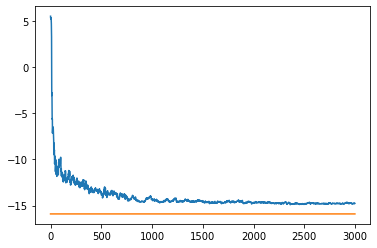

In [35]:
import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(out))]

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)